In [1]:
import pandas as pd
import sys
sys.path.append('../03-code/')
from rdkit import Chem
from config import PROJECT_ROOT_DIRECTORY, IDENTIFIER_DICT, COLUMNS_DICT

In [2]:
organic_genome_dataframe = pd.read_csv(
    PROJECT_ROOT_DIRECTORY + '02-metadata/06-csv-files/01-organic-genome.csv', index_col='identifier'
)
organic_genome_dataframe

smiles_canonical  generation
identifier                                                    
1                     [NH3+]Cc1cc2sc(C[NH3+])cc2s1         2.0
2                      [NH3+]Cc1cc2sc([NH3+])cc2s1         3.0
3                       [NH3+]c1cc2sc([NH3+])cc2s1         4.0
4                          [NH3+]Cc1ccc(C[NH3+])s1         1.0
5                          [NH3+]Cc1ccc(C[NH3+])o1         2.0
...                                            ...         ...
40536         Cc1cc2c(F)c(C(C)[NH3+])sc2cc1C[NH3+]         4.0
40537       Cc1cc(C[NH3+])cc2sc(C(C)[NH3+])c(F)c12         4.0
40538         Cc1c(C[NH3+])cc2sc(C[NH3+])c(F)c2c1C         4.0
40539         Cc1cc2c(F)c(C[NH3+])sc2c(C)c1C[NH3+]         4.0
40540       Cc1c(C[NH3+])cc(C)c2c(F)c(C[NH3+])sc12         4.0

[40540 rows x 2 columns]

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem

# define the reaction smarts dictionary from PDMA as G0 

reaction_smarts_dict = {
    1: AllChem.ReactionFromSmarts('[NH3+:1][C:2]c1ccc([C:3][NH3+:4])cc1>>[NH3+:1][C:2]c1sc([C:3][NH3+:4])cc1'), # benzene thiophene ring exchange 1
    
    2: AllChem.ReactionFromSmarts('[NH3+:1][C:2]c1ccc([C:3][NH3+:4])cc1>>[NH3+:1][C:2]c1scc([C:3][NH3+:4])c1'), # benzene thiophene ring exchange 2

    3: AllChem.ReactionFromSmarts('[c:1][C:2][NH3+:3]>>[c:1](-[c]1[ch]cc([C:2][NH3+:3])c[ch]1)'), # benzene ring linkage
    4: AllChem.ReactionFromSmarts('[c:1][C:2][NH3+:3]>>[c:1]c1csc([C:2][NH3+:3])c1'), # thiophen ring linkage 1
    5: AllChem.ReactionFromSmarts('[c:1][C:2][NH3+:3]>>[c:1]c1sc([C:2][NH3+:3])cc1'), # thiophene ring linkage 2
    6: AllChem.ReactionFromSmarts('[cH:1][c:2][C:3][NH3+:4]>>[c:1]2ccc([C:3][NH3+:4])c[c:2]2'),  # benzene ring fusion
    7: AllChem.ReactionFromSmarts('[cH:1][c:2][C:3][NH3+:4]>>[c:1]2sc([C:3][NH3+:4])c[c:2]2'), # thiophene ring fusion

    8: AllChem.ReactionFromSmarts('[cH:1][c:2][C:3][NH3+:4]>>[cH:2][c:1][C:3][NH3+:4]'), # linker position change

    9: AllChem.ReactionFromSmarts('[c:1][C][NH3+]>>[nH+:1]'), # tethering ammonium exchange

    10: AllChem.ReactionFromSmarts('[#6:1][C:2][NH3+:3]>>[#6:1][C:2][CH2][NH3+:3]'), # linker length increase
    11: AllChem.ReactionFromSmarts('[#6:1][C][NH3+:3]>>[#6:1][NH3+:3]'), # linker length decrease

    12: AllChem.ReactionFromSmarts('[cH:1]>>[n:1]'), # nitrogen substitution

    13: AllChem.ReactionFromSmarts('[s&r5:1]>>[o&r5:1]'), # furan thiophene ring exchange

    14: AllChem.ReactionFromSmarts('[s&r5:1]>>[nH:1]'), # pyrrole thiophene ring exchange

    15: AllChem.ReactionFromSmarts('[cH:1]>>[c:1][F]'), # fluorination

    16: AllChem.ReactionFromSmarts('[#6,#7:1][CH2:2][#6,#7:3]>>[#6,#7:1][CH:2](C)[#6,#7:3]'), # side chain addition on linker
    
    17: AllChem.ReactionFromSmarts('[cH:1]>>[c:1]C'), # side chain addition on backbone

}

In [2]:
# starting from PDMA 
from collections import Counter
import csv

def is_valid_modification(sequence, next_mod):
    """
    Validate if the next modification is allowed based on the sequence and new constraints.
    
    Optimized Constraints:
    - count(1) + count(2) <= 1
    - count(9) <= 1
    - count(13 + 14) <= count(1 + 2 + 4 + 5 + 7)
    - next modification >= last modification except for when last modification is in range 3-7, next modification >= 3.
    - The counts should include both previous modifications and the next modification.

    """
    # Use Counter to get counts of all elements in the sequence efficiently
    counts = Counter(sequence)
    
    # Increment the count of the next modification
    counts[next_mod] += 1

    # Constraint 1: count(1) + count(2) <= 1
    if counts[1] + counts[2] > 1:
        return False

    # Constraint 2: count(9) <= 1
    if counts[9] > 1:
        return False

    # Constraint 3: count(13 + 14) <= count(1 + 2 + 4 + 5 + 7)
    if counts[13] + counts[14] > counts[1] + counts[2] + counts[4] + counts[5] + counts[7]:
        return False

    # Get the last modification in the sequence, or 0 if the sequence is empty
    last_mod = sequence[-1] if sequence else 0

    # Constraint 5: Next modification must be >= last modification
    # except when the last modification is in the range 3-7, next modification must be >= 3.
    if last_mod >= 3 and last_mod <= 7:
        if next_mod < 3:
            return False
    elif next_mod < last_mod:
        return False

    # All constraints satisfied
    return True

def apply_all_reactions_once_with_sequence(input_smiles, sequence, selected_morphing_operator_index=range(1, 18)):
    # input one smiles string and its sequence
    mol = Chem.MolFromSmiles(input_smiles)
    
    unique_smiles_set = set()  # To store unique (SMILES, sequence) pairs
    valid_smiles = [] 

    for next_mod in selected_morphing_operator_index:
        if is_valid_modification(sequence, next_mod):
            rxn = reaction_smarts_dict[next_mod]
            products = rxn.RunReactants((mol,))

            for product_set in products:
                try:
                    Chem.SanitizeMol(product_set[0])
                    smiles = Chem.MolToSmiles(product_set[0])
                    smiles_sequence_pair = (smiles, tuple(sequence + [next_mod]))

                    # Ensure that only unique SMILES and sequences are kept
                    if smiles_sequence_pair not in unique_smiles_set:
                        unique_smiles_set.add(smiles_sequence_pair)
                        valid_smiles.append((smiles, sequence + [next_mod]))
                except:
                    pass
    
    return valid_smiles

def iterative_morphing_operations_to_csv(starting_smiles, sequence, num_iterations, output_file_prefix, selected_morphing_operator_index=range(1, 18)):
    current_smiles_list = [(starting_smiles, sequence)]
    all_seen_smiles = set([starting_smiles])

    for iteration in range(1, num_iterations + 1):
        new_smiles_list = []

        for smiles, seq in current_smiles_list:
            valid_smiles = apply_all_reactions_once_with_sequence(smiles, seq, selected_morphing_operator_index=selected_morphing_operator_index)

            for new_smiles, new_seq in valid_smiles:
                if new_smiles not in all_seen_smiles:
                    new_smiles_list.append((new_smiles, new_seq))
                    all_seen_smiles.add(new_smiles)

        output_file = f"{output_file_prefix}_generation_{iteration}.csv"
        with open(output_file, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(['smiles_canonical', 'Sequence'])
            for smiles, seq in new_smiles_list:
                writer.writerow([smiles, seq])

        print(f"Generation {iteration} completed. Results saved to {output_file}")
        current_smiles_list = new_smiles_list
    return list(all_seen_smiles)

### Type IIb alignment candidates
- use morphing operator: benzene-thiophen ring exchange, linker position change, tethering ammonium exchange, 
linker length decrease, nitrogen substitution, fluorination

In [3]:
type_IIb_morphing_operator_index = [1,2,8,9,10,11,12,13,14,15,16]

In [6]:
starting_mol = Chem.MolFromSmiles('[NH3+]Cc1ccc(C[NH3+])cc1')
starting_smiles = Chem.MolToSmiles(starting_mol)
starting_sequence = []

smiles_list = iterative_morphing_operations_to_csv(starting_smiles, starting_sequence, num_iterations=11, 
                                                   output_file_prefix=PROJECT_ROOT_DIRECTORY+'01-rawdata/19-inverse-design/type_IIb/smiles',
                                                   selected_morphing_operator_index=type_IIb_morphing_operator_index)

Generation 1 completed. Results saved to /Users/yongxinlyu/OneDrive - UNSW/01-bench/DJperovskite/01-rawdata/19-inverse-design/type_IIb/smiles_generation_1.csv
Generation 2 completed. Results saved to /Users/yongxinlyu/OneDrive - UNSW/01-bench/DJperovskite/01-rawdata/19-inverse-design/type_IIb/smiles_generation_2.csv
Generation 3 completed. Results saved to /Users/yongxinlyu/OneDrive - UNSW/01-bench/DJperovskite/01-rawdata/19-inverse-design/type_IIb/smiles_generation_3.csv
Generation 4 completed. Results saved to /Users/yongxinlyu/OneDrive - UNSW/01-bench/DJperovskite/01-rawdata/19-inverse-design/type_IIb/smiles_generation_4.csv
Generation 5 completed. Results saved to /Users/yongxinlyu/OneDrive - UNSW/01-bench/DJperovskite/01-rawdata/19-inverse-design/type_IIb/smiles_generation_5.csv
Generation 6 completed. Results saved to /Users/yongxinlyu/OneDrive - UNSW/01-bench/DJperovskite/01-rawdata/19-inverse-design/type_IIb/smiles_generation_6.csv
Generation 7 completed. Results saved to /User

In [13]:
# figure out the number of smiles generated in each iteration
import ast

type_IIb_smiles_dataframe = pd.DataFrame()
for i in range(1, 12):
    df = pd.read_csv(PROJECT_ROOT_DIRECTORY+'01-rawdata/19-inverse-design/type_IIb/smiles_generation_'+str(i)+'.csv')
    df['generation'] = i
    df['Sequence'] = df['Sequence'].apply(ast.literal_eval)
    # Filtering rows
    filtered_df = df[
        df['Sequence'].apply(lambda x: x.count(9) == 1 and x.count(10)-x.count(11) <=2 and x.count(12) <=4 and x.count(16) <=2)
    ]
    type_IIb_smiles_dataframe = pd.concat([type_IIb_smiles_dataframe, filtered_df],ignore_index=True)


In [14]:
#type_IIb_smiles_dataframe
type_IIb_smiles_dataframe.generation.value_counts().sort_index()

generation
1        1
2       11
3       71
4      262
5      599
6      956
7     1150
8     1074
9      714
10     280
11      48
Name: count, dtype: int64

In [15]:
from organic_featurization_helper import get_organic_structure_descriptors
from utils import predict_mo_lasso, get_alignment_type_prediction
from synthesis_feasibility_helper import calculate_topological_formability_descriptors, calculate_formability_score

for i in type_IIb_smiles_dataframe.index:
    smiles = type_IIb_smiles_dataframe.loc[i, 'smiles_canonical']
    organic_structure_descriptors = get_organic_structure_descriptors(smiles)
    fingerprint_dict = {key: organic_structure_descriptors[key] for key in COLUMNS_DICT['molecular_fingerprint']}
    # Update the dataframe with the new fingerprint values
    for key in fingerprint_dict:
        type_IIb_smiles_dataframe.loc[i, key] = fingerprint_dict[key]

    # predict the energy levels and alignment type
    HOMO_prediction = predict_mo_lasso(fingerprint_dict,target='HOMO')
    LUMO_prediction = predict_mo_lasso(fingerprint_dict,target='LUMO')

    ringcount = fingerprint_dict['ringcount']
    alignment_type_prediction = get_alignment_type_prediction(ringcount, HOMO_prediction, LUMO_prediction)

    type_IIb_smiles_dataframe.loc[i, 'HOMO_prediction'] = HOMO_prediction
    type_IIb_smiles_dataframe.loc[i, 'LUMO_prediction'] = LUMO_prediction
    type_IIb_smiles_dataframe.loc[i, 'alignment_type_prediction'] = alignment_type_prediction

    # formability filter
    mol = Chem.MolFromSmiles(smiles)
    formability_descriptors_dict = calculate_topological_formability_descriptors(mol)

    for key in ['STEI','NumRot_tail','eccentricity','disNN']:
        type_IIb_smiles_dataframe.loc[i, key] = formability_descriptors_dict[key]

    formability_descriptors_dict['linker_position'] = fingerprint_dict['linker_position']
    formability_score_list = calculate_formability_score(formability_descriptors_dict, smearing_factor=0.15)

    type_IIb_smiles_dataframe.loc[i, 'formability_score'] = formability_score_list['formability_score']

type_IIb_smiles_dataframe

smiles_canonical  \
0                       [NH3+]Cc1cc[nH+]cc1   
1                        [NH3+]Cc1cc[nH+]s1   
2                        [NH3+]Cc1c[nH+]cs1   
3                        [NH3+]Cc1c[nH+]sc1   
4                       [NH3+]Cc1ccc[nH+]c1   
...                                     ...   
5161     CC([NH3+])CC(C)c1[nH+]nc(F)c(F)c1F   
5162     CC(C[NH3+])C(C)c1[nH+]nc(F)c(F)c1F   
5163  CC([NH3+])C(C)Cc1[nH+]c(F)c(F)c(F)c1F   
5164  CC([NH3+])CC(C)c1[nH+]c(F)c(F)c(F)c1F   
5165  CC(C[NH3+])C(C)c1[nH+]c(F)c(F)c(F)c1F   

                                       Sequence  generation  ringcount  \
0                                           [9]           1        1.0   
1                                        [1, 9]           2        1.0   
2                                        [2, 9]           2        1.0   
3                                        [2, 9]           2        1.0   
4                                        [8, 9]           2        1.0   
...                                         ...         ...        ...   
5161  [8, 8, 9, 10, 10, 12, 15, 15, 15, 16, 16]          11        1.0   
5162  [8, 8, 9, 10, 10, 12, 15, 15, 15, 16, 16]          11        1.0   
5163  [8, 8, 9, 10, 10, 15, 15, 15, 15, 16, 16]          11        1.0   
5164  [8, 8, 9, 10, 10, 15, 15, 15, 15, 16, 16]          11        1.0   
5165  [8, 8, 9, 10, 10, 15, 15, 15, 15, 16, 16]          11        1.0   

      linkage_p  six_ring_p  primaryamine  linker_length  linker_position  \
0           0.0         1.0           1.0            1.0         1.000000   
1           0.0         0.0           1.0            1.0         1.000000   
2           0.0         0.0           1.0            1.0         1.000000   
3           0.0         0.0           1.0            1.0         1.000000   
4           0.0         1.0           1.0            1.0         0.666667   
...         ...         ...           ...            ...              ...   
5161        0.0         1.0           1.0            3.0         0.333333   
5162        0.0         1.0           1.0            3.0         0.333333   
5163        0.0         1.0           1.0            3.0         0.333333   
5164        0.0         1.0           1.0            3.0         0.333333   
5165        0.0         1.0           1.0            3.0         0.333333   

      hetero_nitrogen  ...  sidechain_on_linker  sidechain_on_backbone  \
0                 0.0  ...                  0.0                    0.0   
1                 0.0  ...                  0.0                    0.0   
2                 0.0  ...                  0.0                    0.0   
3                 0.0  ...                  0.0                    0.0   
4                 0.0  ...                  0.0                    0.0   
...               ...  ...                  ...                    ...   
5161              1.0  ...                  2.0                    0.0   
5162              1.0  ...                  2.0                    0.0   
5163              0.0  ...                  2.0                    0.0   
5164              0.0  ...                  2.0                    0.0   
5165              0.0  ...                  2.0                    0.0   

      HOMO_prediction  LUMO_prediction  alignment_type_prediction      STEI  \
0          -15.912665       -10.644682                         Ia  2.310662   
1          -15.940573       -10.750671                         Ia  2.302662   
2          -15.940573       -10.750671                         Ia  2.302662   
3          -15.940573       -10.750671                         Ia  2.302662   
4          -15.947470       -10.631970                         Ia  2.339699   
...               ...              ...                        ...       ...   
5161       -14.991208       -10.050639                         Ia  2.607435   
5162       -14.991208       -10.050639                         Ia  2.615060   
5163       -14.686427        -9.780109          

In [16]:
# filter alignment type and fingerprint vector
# Define ranges for each column

type_IIb_fingerprint_criteria = 'alignment_type_prediction == "IIb" and ringcount == 1 and linkage_p == 0 and six_ring_p >= 0 and six_ring_p <= 1 and primaryamine == 1 and linker_length <= 3 and linker_position <= 1 and hetero_nitrogen <= 4 and fluorination <= 2 and furan <= 1 and pyrrole <= 1 and sidechain_on_linker <= 2 and sidechain_on_backbone == 0'

type_IIb_filtered_dataframe = type_IIb_smiles_dataframe.query(type_IIb_fingerprint_criteria)
type_IIb_filtered_dataframe.reset_index(drop=True, inplace=True)

In [17]:
type_IIb_filtered_dataframe

smiles_canonical                               Sequence  \
0               [NH3+]c1cc[nH+]cc1                                [9, 11]   
1              [NH3+]Cc1cc[nH+]cn1                                [9, 12]   
2              [NH3+]Cc1cc[nH+]nc1                                [9, 12]   
3                [NH3+]c1cc[nH+]s1                             [1, 9, 11]   
4               [NH3+]Cc1nc[nH+]s1                             [1, 9, 12]   
..                             ...                                    ...   
818     CC([NH3+])C(C)c1nnnn[nH+]1  [8, 8, 9, 10, 12, 12, 12, 12, 16, 16]   
819  CC([NH3+])C(C)c1nnnc(F)[nH+]1  [8, 8, 9, 10, 12, 12, 12, 15, 16, 16]   
820  CC([NH3+])C(C)c1nnc(F)n[nH+]1  [8, 8, 9, 10, 12, 12, 12, 15, 16, 16]   
821  CC([NH3+])C(C)c1nc(F)nn[nH+]1  [8, 8, 9, 10, 12, 12, 12, 15, 16, 16]   
822    CC([NH3+])C(C)c1[nH+]nnnc1F  [8, 8, 9, 10, 12, 12, 12, 15, 16, 16]   

     generation  ringcount  linkage_p  six_ring_p  primaryamine  \
0             2        1.0        0.0         1.0           1.0   
1             2        1.0        0.0         1.0           1.0   
2             2        1.0        0.0         1.0           1.0   
3             3        1.0        0.0         0.0           1.0   
4             3        1.0        0.0         0.0           1.0   
..          ...        ...        ...         ...           ...   
818          10        1.0        0.0         1.0           1.0   
819          10        1.0        0.0         1.0           1.0   
820          10        1.0        0.0         1.0           1.0   
821          10        1.0        0.0         1.0           1.0   
822          10        1.0        0.0         1.0           1.0   

     linker_length  linker_position  hetero_nitrogen  ...  \
0              0.0         1.000000              0.0  ...   
1              1.0         1.000000              1.0  ...   
2              1.0         1.000000              1.0  ...   
3              0.0         1.000000              0.0  ...   
4              1.0         1.000000              1.0  ...   
..             ...              ...              ...  ...   
818            2.0         0.333333              4.0  ...   
819            2.0         0.333333              3.0  ...   
820            2.0         0.333333              3.0  ...   
821            2.0         0.333333              3.0  ...   
822            2.0         0.333333              3.0  ...   

     sidechain_on_linker  sidechain_on_backbone  HOMO_prediction  \
0                    0.0                    0.0       -16.439109   
1                    0.0                    0.0       -16.217445   
2                    0.0                    0.0       -16.217445   
3                    0.0                    0.0       -16.467017   
4                    0.0                    0.0       -16.245353   
..                   ...                    ...              ...   
818                  2.0                    0.0       -16.431992   
819                  2.0                    0.0       -16.127212   
820                  2.0                    0.0       -16.127212   
821                  2.0                    0.0       -16.127212   
822                  2.0                    0.0       -16.127212   

     LUMO_prediction  alignment_type_prediction      STEI  NumRot_tail  \
0         -11.150217                        IIb  2.302662          0.5   
1         -11.025224                        IIb  2.310662          1.0   
2         -11.025224                        IIb  2.310662          1.0   
3         -11.256206                        IIb  2.287037          0.5   
4         -11.131213                        IIb  2.302662          1.0   
..               ...                        ...       ...          ...   
818       -11.367765                        IIb  2.517361          1.5   
819       -11.097234                        IIb  2.642361          1.5   
820       -11.097234                        IIb  2.554398          1.5  

In [18]:
type_IIb_filtered_dataframe.to_csv(PROJECT_ROOT_DIRECTORY+'01-rawdata/19-inverse-design/type_IIb/type_IIb_candidates.csv', index=False)

In [20]:
type_IIb_filtered_dataframe

formability_score
0.444640    33
0.363447    27
0.230822    25
0.965091    21
0.310834    19
            ..
0.814851     1
0.812483     1
0.981456     1
0.978151     1
0.595548     1
Name: count, Length: 156, dtype: int64

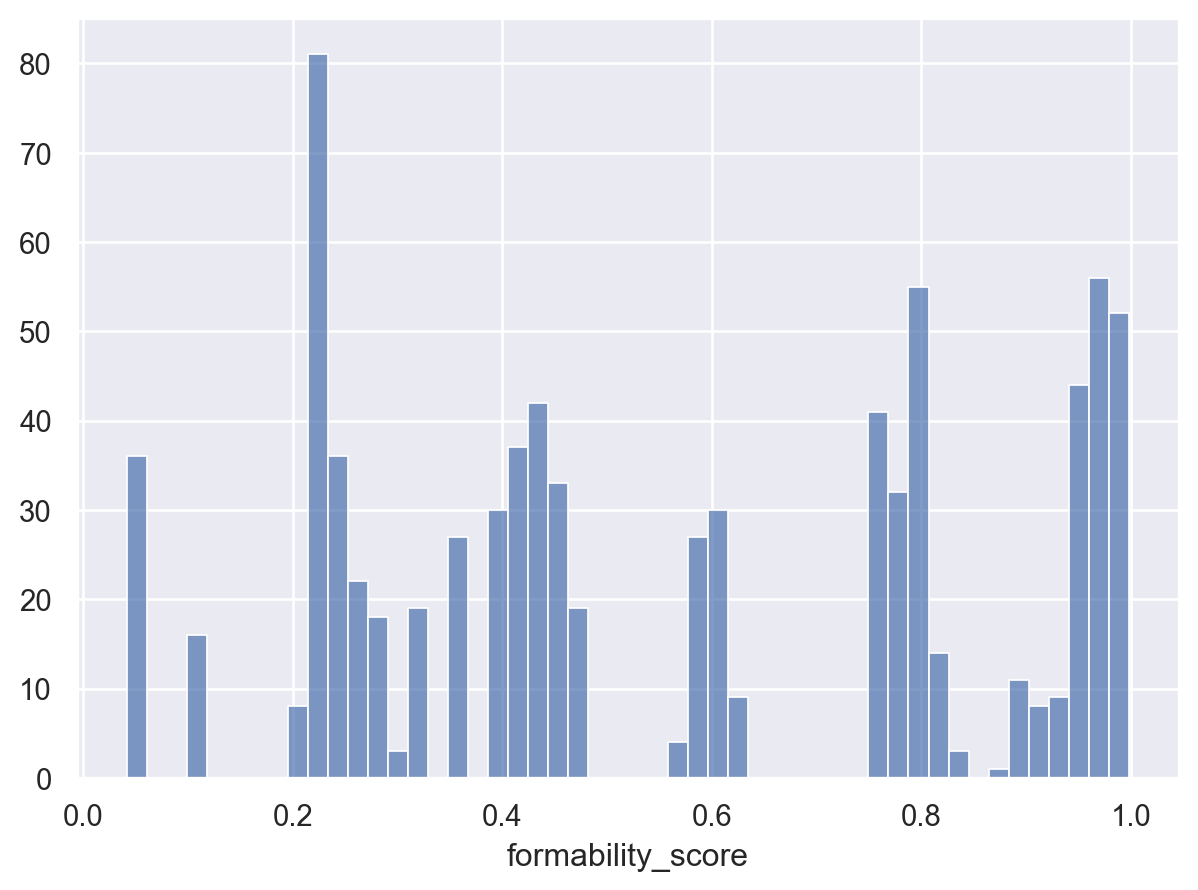

In [23]:
# plot distribution of formability score
import seaborn.objects as so
(
    so.Plot(type_IIb_filtered_dataframe, x='formability_score')
    .add(so.Bars(), so.Hist(bins=50))
)

In [35]:
type_IIb_selected_dataframe = type_IIb_filtered_dataframe.query('formability_score >= 0.85').reset_index(drop=True)
print(type_IIb_selected_dataframe.generation.value_counts().sort_index())
print(len(type_IIb_selected_dataframe.index))


generation
2     2
3    17
4    36
5    48
6    38
7    22
8    12
9     6
Name: count, dtype: int64
181


In [36]:
from organic_featurization_helper import get_organic_existence, get_neutral_smiles

for i in type_IIb_selected_dataframe.index:
    smiles_canonical = type_IIb_selected_dataframe.loc[i, 'smiles_canonical']
    smiles_neutral = get_neutral_smiles(smiles_canonical)
                
    # Find the existence of molecule in pubchem
    organic_existence_dict = get_organic_existence(smiles_neutral)
    for key in organic_existence_dict:
        type_IIb_selected_dataframe.loc[i, key] = organic_existence_dict[key]

In [37]:
for index in type_IIb_selected_dataframe.index:
    if type_IIb_selected_dataframe.loc[index, 'cid'] >0:
        type_IIb_selected_dataframe.loc[index, 'PubChem_existence'] = True
    else:
        type_IIb_selected_dataframe.loc[index, 'PubChem_existence'] = False

In [99]:
print(type_IIb_selected_dataframe.PubChem_existence.value_counts())
type_IIb_selected_dataframe.to_csv(PROJECT_ROOT_DIRECTORY+'01-rawdata/19-inverse-design/type_IIb/type_IIb_selected_candidates.csv', index=False)

PubChem_existence
False    121
True      60
Name: count, dtype: int64


In [46]:
print(type_IIb_selected_dataframe.PubChem_existence.value_counts())
type_IIb_final_candidates = type_IIb_selected_dataframe.query('PubChem_existence == True').reset_index(drop=True)
print(type_IIb_final_candidates.generation.value_counts().sort_index())
print(len(type_IIb_final_candidates.index))
type_IIb_final_candidates = type_IIb_final_candidates.sort_values(by='formability_score', ascending=False)
type_IIb_final_candidates.to_csv(PROJECT_ROOT_DIRECTORY+'01-rawdata/19-inverse-design/type_IIb/type_IIb_synthesizable_candidates.csv', index=False)

PubChem_existence
False    121
True      60
Name: count, dtype: int64
generation
2     2
3    15
4    21
5    16
6     6
Name: count, dtype: int64
60


In [48]:
type_IIb_final_candidates

smiles_canonical                Sequence  generation  ringcount  \
41       [NH3+]CCc1n[nH+]ns1      [2, 9, 10, 12, 12]           5        1.0   
38       [NH3+]CCc1nn[nH+]s1      [1, 9, 10, 12, 12]           5        1.0   
59      [NH3+]CCc1nnc[nH+]n1  [8, 9, 10, 12, 12, 12]           6        1.0   
12       [NH3+]Cc1nc[nH+]cn1             [9, 12, 12]           3        1.0   
34       [NH3+]Cc1cn[nH+]nn1         [9, 12, 12, 12]           4        1.0   
32       [NH3+]Cc1nc[nH+]nn1         [9, 12, 12, 12]           4        1.0   
1        [NH3+]Cc1cc[nH+]nc1                 [9, 12]           2        1.0   
16       [NH3+]Cc1cn[nH+]nc1             [9, 12, 12]           3        1.0   
14       [NH3+]Cc1cc[nH+]nn1             [9, 12, 12]           3        1.0   
13       [NH3+]Cc1cn[nH+]cn1             [9, 12, 12]           3        1.0   
0        [NH3+]Cc1cc[nH+]cn1                 [9, 12]           2        1.0   
35    CC([NH3+])c1cn[nH+]cn1         [9, 12, 12, 16]           4        1.0   
36    CC([NH3+])c1cc[nH+]nn1         [9, 12, 12, 16]           4        1.0   
33    CC([NH3+])c1nc[nH+]cn1         [9, 12, 12, 16]           4        1.0   
15      [NH3+]Cc1nc[nH+]cc1F             [9, 12, 15]           3        1.0   
37   CC([NH3+])c1nc[nH+]cc1F         [9, 12, 15, 16]           4        1.0   
23        [NH3+]Cc1co[nH+]n1          [2, 9, 12, 13]           4        1.0   
4         [NH3+]Cc1n[nH+]cs1              [2, 9, 12]           3        1.0   
6         [NH3+]Cc1cs[nH+]n1              [2, 9, 12]           3        1.0   
44     [NH3+]Cc1n[nH][nH+]n1      [2, 9, 12, 12, 14]           5        1.0   
42     [NH3+]Cc1n[nH+]n[nH]1      [2, 9, 12, 12, 14]           5        1.0   
2         [NH3+]Cc1nc[nH+]s1              [1, 9, 12]           3        1.0   
24        [NH3+]Cc1c[nH+]on1          [2, 9, 12, 13]           4        1.0   
22        [NH3+]Cc1c[nH+]no1          [2, 9, 12, 13]           4        1.0   
21        [NH3+]Cc1n[nH+]co1          [2, 9, 12, 13]           4        1.0   
20        [NH3+]Cc1n[nH+]ns1          [2, 9, 12, 12]           4        1.0   
19        [NH3+]Cc1cn[nH+]o1          [1, 9, 12, 13]           4        1.0   
18        [NH3+]Cc1nc[nH+]o1          [1, 9, 12, 13]           4        1.0   
17        [NH3+]Cc1nn[nH+]s1          [1, 9, 12, 12]           4        1.0   
7         [NH3+]Cc1c[nH+]sn1              [2, 9, 12]           3        1.0   
3         [NH3+]Cc1cn[nH+]s1              [1, 9, 12]           3        1.0   
39     [NH3+]Cc1nn[nH+][nH]1      [1, 9, 12, 12, 14]           5        1.0   
5         [NH3+]Cc1c[nH+]ns1              [2, 9, 12]           3        1.0   
40     CC([NH3+])c1nn[nH+]s1      [1, 9, 12, 12, 16]           5        1.0   
43     CC([NH3+])c1n[nH+]ns1      [2, 9, 12, 12, 16]           5        1.0   
54  CC([NH3+])c1nn[nH+][nH]1  [1, 9, 12, 12, 14, 16]           6        1.0   
57  CC([NH3+])c1n[nH+]n[nH]1  [2, 9, 12, 12, 14, 16]           6        1.0   
58  CC([NH3+])c1n[nH][nH+]n1  [2, 9, 12, 12, 14, 16]           6        1.0   
45       [NH3+]Cc1nnc[nH+]n1      [8, 9, 12, 12, 12]           5        1.0   
46       [NH3+]Cc1ncn[nH+]n1      [8, 9, 12, 12, 12]           5        1.0   
51       [NH3+]Cc1cnn[nH+]n1      [8, 9, 12, 12, 12]           5        1.0   
11       [NH3+]Cc1ccc[nH+]n1              [8, 9, 12]           3        1.0   
10       [NH3+]Cc1ccn[nH+]c1              [8, 9, 12]           3        1.0   
31       [NH3+]Cc1ccn[nH+]n1          [8, 9, 12, 12]           4        1.0   
9        [NH3+]Cc1cnc[nH+]c1              [8, 9, 12]           3        1.0   
25       [NH3+]Cc1ncc[nH+]n1          [8, 9, 12, 12]           4        1.0   
30       [NH3+]Cc1cnc[nH+]n1          [8, 9, 12, 12]           4        1.0   
29       [NH3+]Cc1cnn[nH+]c1          [8, 9, 12, 12]           4        1.0   
48       [NH3+]Cc1c[nH+]nnn1      [8, 9, 12, 12, 12]           5        1.0   
27       [NH3+]Cc1c[nH+]cnn1          [8, 9, 12, 12]          

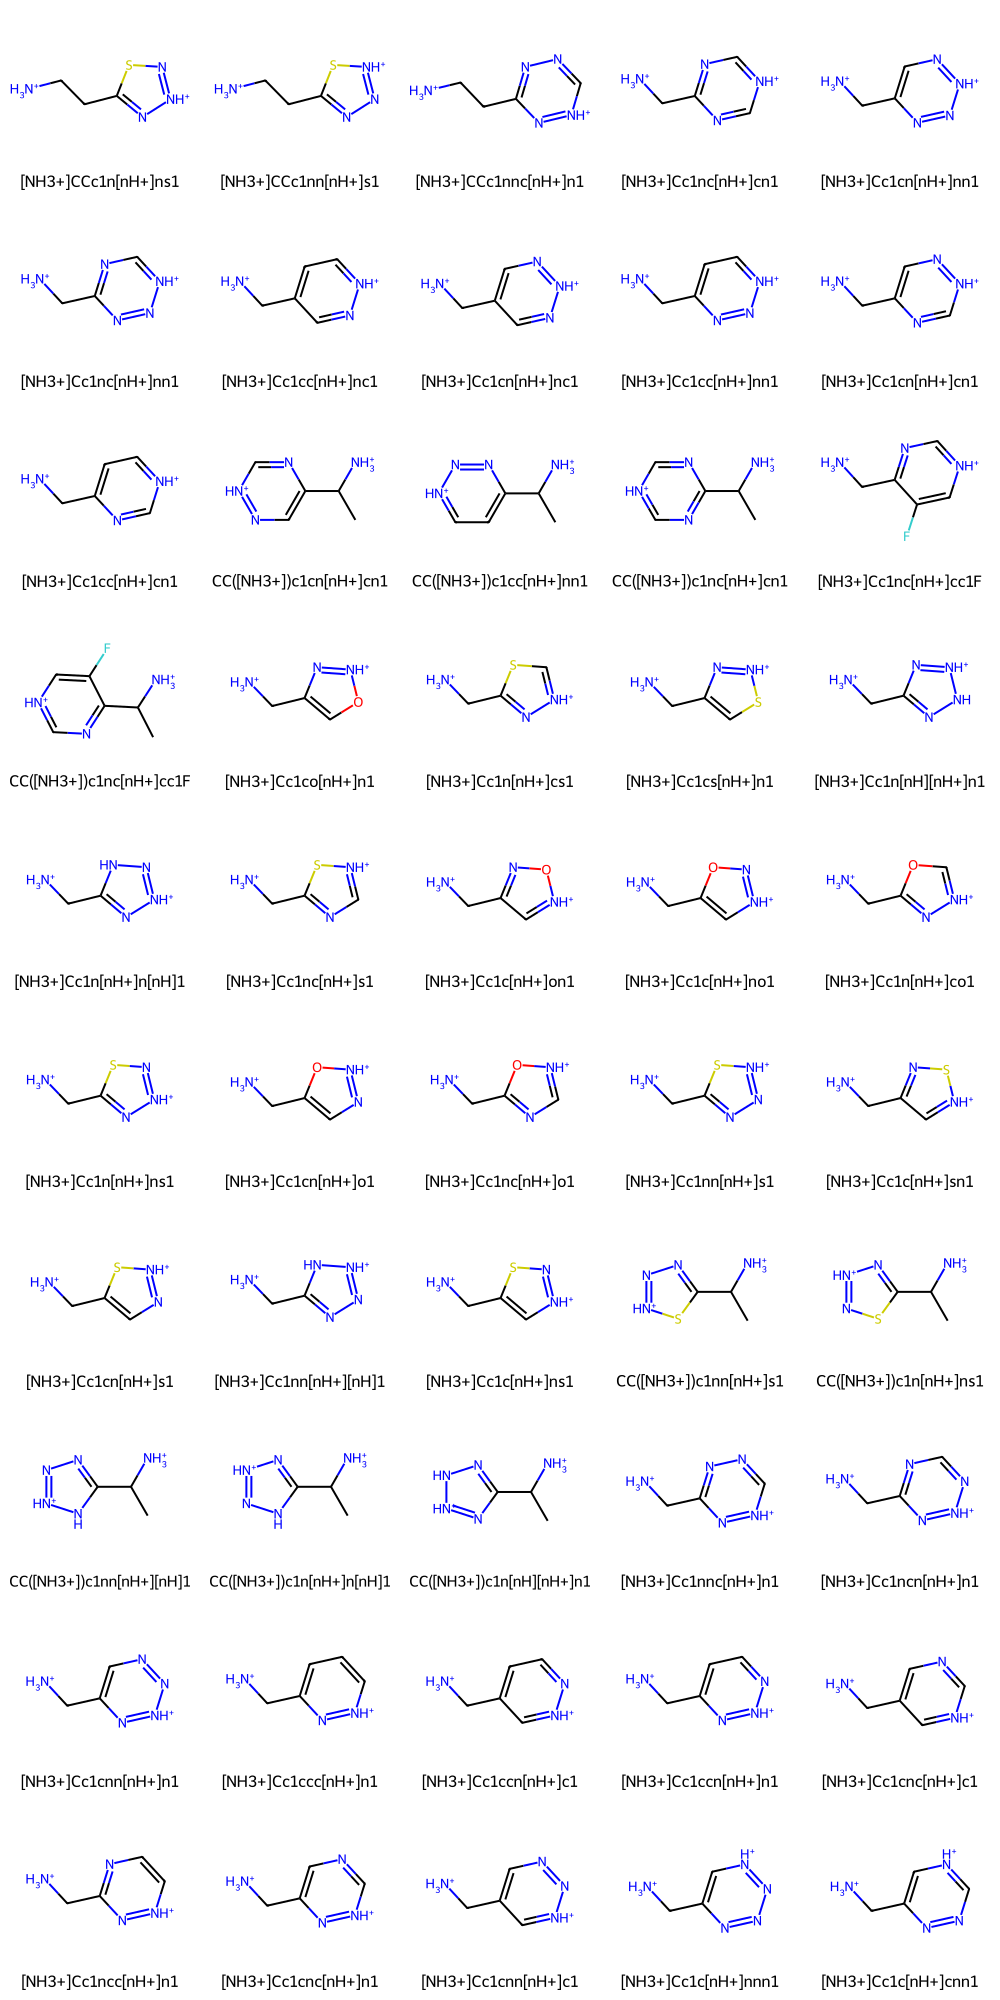

In [47]:
from utils import visualize_smiles_list
smiles_list = type_IIb_final_candidates.smiles_canonical.to_list()
visualize_smiles_list(smiles_list[:50])

### Type Ib alignment

In [49]:
type_Ib_morphing_operator_index = [6,8,11] 

In [50]:
starting_mol = Chem.MolFromSmiles('[NH3+]Cc1ccc2cc3cc4cc5cc(C[NH3+])ccc5cc4cc3cc2c1')
starting_smiles = Chem.MolToSmiles(starting_mol)
starting_sequence = [6,6,6,6]

smiles_list = iterative_morphing_operations_to_csv(starting_smiles, starting_sequence, num_iterations=7, 
                                                   output_file_prefix=PROJECT_ROOT_DIRECTORY+'01-rawdata/19-inverse-design/type_Ib/smiles',
                                                   selected_morphing_operator_index=type_Ib_morphing_operator_index)

Generation 1 completed. Results saved to /Users/yongxinlyu/OneDrive - UNSW/01-bench/DJperovskite/01-rawdata/19-inverse-design/type_Ib/smiles_generation_1.csv
Generation 2 completed. Results saved to /Users/yongxinlyu/OneDrive - UNSW/01-bench/DJperovskite/01-rawdata/19-inverse-design/type_Ib/smiles_generation_2.csv
Generation 3 completed. Results saved to /Users/yongxinlyu/OneDrive - UNSW/01-bench/DJperovskite/01-rawdata/19-inverse-design/type_Ib/smiles_generation_3.csv
Generation 4 completed. Results saved to /Users/yongxinlyu/OneDrive - UNSW/01-bench/DJperovskite/01-rawdata/19-inverse-design/type_Ib/smiles_generation_4.csv
Generation 5 completed. Results saved to /Users/yongxinlyu/OneDrive - UNSW/01-bench/DJperovskite/01-rawdata/19-inverse-design/type_Ib/smiles_generation_5.csv
Generation 6 completed. Results saved to /Users/yongxinlyu/OneDrive - UNSW/01-bench/DJperovskite/01-rawdata/19-inverse-design/type_Ib/smiles_generation_6.csv
Generation 7 completed. Results saved to /Users/yong

In [51]:
# figure out the number of smiles generated in each iteration
import ast
type_Ib_smiles_dataframe = pd.DataFrame()
for i in range(1, 8):
    df = pd.read_csv(PROJECT_ROOT_DIRECTORY+'01-rawdata/19-inverse-design/type_Ib/smiles_generation_'+str(i)+'.csv')
    df['generation'] = i+4

    df['Sequence'] = df['Sequence'].apply(ast.literal_eval)
    # Filtering rows
    filtered_df = df[
        df['Sequence'].apply(lambda x: x.count(6) <= 6)
    ]
    type_Ib_smiles_dataframe = pd.concat([type_Ib_smiles_dataframe, filtered_df],ignore_index=True)
type_Ib_smiles_dataframe

smiles_canonical  \
0    [NH3+]Cc1ccc2cc3cc4cc5cc6cc(C[NH3+])ccc6cc5cc4...   
1    [NH3+]Cc1ccc2cc3cc4cc5c(ccc6cc(C[NH3+])ccc65)c...   
2     [NH3+]Cc1ccc2cc3cc4cc5ccc(C[NH3+])cc5cc4cc3cc2c1   
3     [NH3+]Cc1ccc2cc3cc4cc5c(C[NH3+])cccc5cc4cc3cc2c1   
4      [NH3+]Cc1ccc2cc3cc4cc5cc([NH3+])ccc5cc4cc3cc2c1   
..                                                 ...   
342  [NH3+]c1cccc2cc3cc4cc5c(ccc6cc7cccc([NH3+])c7c...   
343  [NH3+]Cc1cccc2ccc3cc4cc5cc6c(ccc7cccc([NH3+])c...   
344  [NH3+]c1ccc2ccc3cc4cc5cc6c(ccc7cccc([NH3+])c76...   
345  [NH3+]c1cccc2c1ccc1cc3cc4cc5c(ccc6cccc([NH3+])...   
346  [NH3+]c1cccc2cc3cc4cc5ccc6cccc([NH3+])c6c5cc4c...   

                                Sequence  generation  
0                        [6, 6, 6, 6, 6]           5  
1                        [6, 6, 6, 6, 6]           5  
2                        [6, 6, 6, 6, 8]           5  
3                        [6, 6, 6, 6, 8]           5  
4                       [6, 6, 6, 6, 11]           5  
..                                   ...         ...  
342  [6, 6, 6, 6, 6, 6, 8, 8, 8, 11, 11]          11  
343   [6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 11]          11  
344  [6, 6, 6, 6, 6, 6, 8, 8, 8, 11, 11]          11  
345  [6, 6, 6, 6, 6, 6, 8, 8, 8, 11, 11]          11  
346  [6, 6, 6, 6, 6, 8, 8, 8, 8, 11, 11]          11  

[347 rows x 3 columns]

In [52]:
type_Ib_smiles_dataframe.generation.value_counts().sort_index()

generation
5      5
6     20
7     51
8     89
9     95
10    64
11    23
Name: count, dtype: int64

In [49]:
type_Ib_smiles_dataframe.generation.value_counts().sort_index()

generation
5        5
6       20
7       62
8      175
9      442
10    1063
11    2423
Name: count, dtype: int64

In [54]:
from organic_featurization_helper import get_organic_structure_descriptors
from utils import predict_mo_lasso, get_alignment_type_prediction
from synthesis_feasibility_helper import calculate_topological_formability_descriptors, calculate_formability_score

for i in type_Ib_smiles_dataframe.index:
    smiles = type_Ib_smiles_dataframe.loc[i, 'smiles_canonical']
    organic_structure_descriptors = get_organic_structure_descriptors(smiles)
    fingerprint_dict = {key: organic_structure_descriptors[key] for key in COLUMNS_DICT['molecular_fingerprint']}
    # Update the dataframe with the new fingerprint values
    for key in fingerprint_dict:
        type_Ib_smiles_dataframe.loc[i, key] = fingerprint_dict[key]

    # predict the energy levels and alignment type
    HOMO_prediction = predict_mo_lasso(fingerprint_dict,target='HOMO')
    LUMO_prediction = predict_mo_lasso(fingerprint_dict,target='LUMO')

    ringcount = fingerprint_dict['ringcount']
    #alignment_type_prediction = get_alignment_type_prediction(ringcount, HOMO_prediction, LUMO_prediction)

    type_Ib_smiles_dataframe.loc[i, 'HOMO_prediction'] = HOMO_prediction
    type_Ib_smiles_dataframe.loc[i, 'LUMO_prediction'] = LUMO_prediction
    type_Ib_smiles_dataframe.loc[i, 'alignment_type_prediction'] = 'Ib'

    # formability filter
    mol = Chem.MolFromSmiles(smiles)
    formability_descriptors_dict = calculate_topological_formability_descriptors(mol)

    for key in ['STEI','NumRot_tail','eccentricity','disNN']:
        type_Ib_smiles_dataframe.loc[i, key] = formability_descriptors_dict[key]

    formability_descriptors_dict['linker_position'] = fingerprint_dict['linker_position']
    formability_score_list = calculate_formability_score(formability_descriptors_dict, smearing_factor=0.15)

    type_Ib_smiles_dataframe.loc[i, 'formability_score'] = formability_score_list['formability_score']

type_Ib_smiles_dataframe

smiles_canonical  \
0    [NH3+]Cc1ccc2cc3cc4cc5cc6cc(C[NH3+])ccc6cc5cc4...   
1    [NH3+]Cc1ccc2cc3cc4cc5c(ccc6cc(C[NH3+])ccc65)c...   
2     [NH3+]Cc1ccc2cc3cc4cc5ccc(C[NH3+])cc5cc4cc3cc2c1   
3     [NH3+]Cc1ccc2cc3cc4cc5c(C[NH3+])cccc5cc4cc3cc2c1   
4      [NH3+]Cc1ccc2cc3cc4cc5cc([NH3+])ccc5cc4cc3cc2c1   
..                                                 ...   
342  [NH3+]c1cccc2cc3cc4cc5c(ccc6cc7cccc([NH3+])c7c...   
343  [NH3+]Cc1cccc2ccc3cc4cc5cc6c(ccc7cccc([NH3+])c...   
344  [NH3+]c1ccc2ccc3cc4cc5cc6c(ccc7cccc([NH3+])c76...   
345  [NH3+]c1cccc2c1ccc1cc3cc4cc5c(ccc6cccc([NH3+])...   
346  [NH3+]c1cccc2cc3cc4cc5ccc6cccc([NH3+])c6c5cc4c...   

                                Sequence  generation  ringcount  linkage_p  \
0                        [6, 6, 6, 6, 6]           5        6.0        0.0   
1                        [6, 6, 6, 6, 6]           5        6.0        0.0   
2                        [6, 6, 6, 6, 8]           5        5.0        0.0   
3                        [6, 6, 6, 6, 8]           5        5.0        0.0   
4                       [6, 6, 6, 6, 11]           5        5.0        0.0   
..                                   ...         ...        ...        ...   
342  [6, 6, 6, 6, 6, 6, 8, 8, 8, 11, 11]          11        7.0        0.0   
343   [6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 11]          11        7.0        0.0   
344  [6, 6, 6, 6, 6, 6, 8, 8, 8, 11, 11]          11        7.0        0.0   
345  [6, 6, 6, 6, 6, 6, 8, 8, 8, 11, 11]          11        7.0        0.0   
346  [6, 6, 6, 6, 6, 8, 8, 8, 8, 11, 11]          11        6.0        0.0   

     six_ring_p  primaryamine  linker_length  linker_position  \
0           1.0           2.0            2.0         1.000000   
1           1.0           2.0            2.0         1.000000   
2           1.0           2.0            2.0         0.909091   
3           1.0           2.0            2.0         0.909091   
4           1.0           2.0            1.0         1.000000   
..          ...           ...            ...              ...   
342         1.0           2.0            0.0         0.800000   
343         1.0           2.0            1.0         0.733333   
344         1.0           2.0            0.0         0.800000   
345         1.0           2.0            0.0         0.800000   
346         1.0           2.0            0.0         0.692308   

     hetero_nitrogen  ...  sidechain_on_linker  sidechain_on_backbone  \
0                0.0  ...                  0.0                    0.0   
1                0.0  ...                  0.0                    0.0   
2                0.0  ...                  0.0                    0.0   
3                0.0  ...                  0.0                    0.0   
4                0.0  ...                  0.0                    0.0   
..               ...  ...                  ...                    ...   
342              0.0  ...                  0.0                    0.0   
343              0.0  ...                  0.0                    0.0   
344              0.0  ...                  0.0                    0.0   
345              0.0  ...                  0.0                    0.0   
346              0.0  ...                  0.0                    0.0   

     HOMO_prediction  LUMO_prediction  alignment_type_prediction      STEI  \
0          -7.379400        -5.608637                         Ib  1.275107   
1          -7.379400        -5.608637                         Ib  1.275107   
2          -8.725323        -6.139211                         Ib  1.273999   
3          -8.725323        -6.139211                         Ib  1.296590   
4          -9.242275        -6.648213                         Ib  1.397965   
..               ...              ...                        ...       ...   
342        -7.116741        -6.078039                         Ib  1.459570   
343        -6.597258        -5.569961                         Ib  1.476105   
344        -7.116741        -6.078039       

In [55]:
# filter alignment type and fingerprint vector
# Define ranges for each column

type_Ib_fingerprint_criteria = 'alignment_type_prediction == "Ib" and ringcount >= 5 and ringcount <= 7 and linkage_p == 0 and six_ring_p == 1 and primaryamine == 2 and linker_length <= 2 and linker_position <= 1 and linker_position >=0.5 and hetero_nitrogen == 0 and fluorination == 0 and furan == 0 and pyrrole == 0 and sidechain_on_linker == 0 and sidechain_on_backbone == 0'

type_Ib_filtered_dataframe = type_Ib_smiles_dataframe.query(type_Ib_fingerprint_criteria).reset_index(drop=True)

type_Ib_filtered_dataframe

smiles_canonical  \
0    [NH3+]Cc1ccc2cc3cc4cc5cc6cc(C[NH3+])ccc6cc5cc4...   
1    [NH3+]Cc1ccc2cc3cc4cc5c(ccc6cc(C[NH3+])ccc65)c...   
2     [NH3+]Cc1ccc2cc3cc4cc5ccc(C[NH3+])cc5cc4cc3cc2c1   
3     [NH3+]Cc1ccc2cc3cc4cc5c(C[NH3+])cccc5cc4cc3cc2c1   
4      [NH3+]Cc1ccc2cc3cc4cc5cc([NH3+])ccc5cc4cc3cc2c1   
..                                                 ...   
342  [NH3+]c1cccc2cc3cc4cc5c(ccc6cc7cccc([NH3+])c7c...   
343  [NH3+]Cc1cccc2ccc3cc4cc5cc6c(ccc7cccc([NH3+])c...   
344  [NH3+]c1ccc2ccc3cc4cc5cc6c(ccc7cccc([NH3+])c76...   
345  [NH3+]c1cccc2c1ccc1cc3cc4cc5c(ccc6cccc([NH3+])...   
346  [NH3+]c1cccc2cc3cc4cc5ccc6cccc([NH3+])c6c5cc4c...   

                                Sequence  generation  ringcount  linkage_p  \
0                        [6, 6, 6, 6, 6]           5        6.0        0.0   
1                        [6, 6, 6, 6, 6]           5        6.0        0.0   
2                        [6, 6, 6, 6, 8]           5        5.0        0.0   
3                        [6, 6, 6, 6, 8]           5        5.0        0.0   
4                       [6, 6, 6, 6, 11]           5        5.0        0.0   
..                                   ...         ...        ...        ...   
342  [6, 6, 6, 6, 6, 6, 8, 8, 8, 11, 11]          11        7.0        0.0   
343   [6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 11]          11        7.0        0.0   
344  [6, 6, 6, 6, 6, 6, 8, 8, 8, 11, 11]          11        7.0        0.0   
345  [6, 6, 6, 6, 6, 6, 8, 8, 8, 11, 11]          11        7.0        0.0   
346  [6, 6, 6, 6, 6, 8, 8, 8, 8, 11, 11]          11        6.0        0.0   

     six_ring_p  primaryamine  linker_length  linker_position  \
0           1.0           2.0            2.0         1.000000   
1           1.0           2.0            2.0         1.000000   
2           1.0           2.0            2.0         0.909091   
3           1.0           2.0            2.0         0.909091   
4           1.0           2.0            1.0         1.000000   
..          ...           ...            ...              ...   
342         1.0           2.0            0.0         0.800000   
343         1.0           2.0            1.0         0.733333   
344         1.0           2.0            0.0         0.800000   
345         1.0           2.0            0.0         0.800000   
346         1.0           2.0            0.0         0.692308   

     hetero_nitrogen  ...  sidechain_on_linker  sidechain_on_backbone  \
0                0.0  ...                  0.0                    0.0   
1                0.0  ...                  0.0                    0.0   
2                0.0  ...                  0.0                    0.0   
3                0.0  ...                  0.0                    0.0   
4                0.0  ...                  0.0                    0.0   
..               ...  ...                  ...                    ...   
342              0.0  ...                  0.0                    0.0   
343              0.0  ...                  0.0                    0.0   
344              0.0  ...                  0.0                    0.0   
345              0.0  ...                  0.0                    0.0   
346              0.0  ...                  0.0                    0.0   

     HOMO_prediction  LUMO_prediction  alignment_type_prediction      STEI  \
0          -7.379400        -5.608637                         Ib  1.275107   
1          -7.379400        -5.608637                         Ib  1.275107   
2          -8.725323        -6.139211                         Ib  1.273999   
3          -8.725323        -6.139211                         Ib  1.296590   
4          -9.242275        -6.648213                         Ib  1.397965   
..               ...              ...                        ...       ...   
342        -7.116741        -6.078039                         Ib  1.459570   
343        -6.597258        -5.569961                         Ib  1.476105   
344        -7.116741        -6.078039       

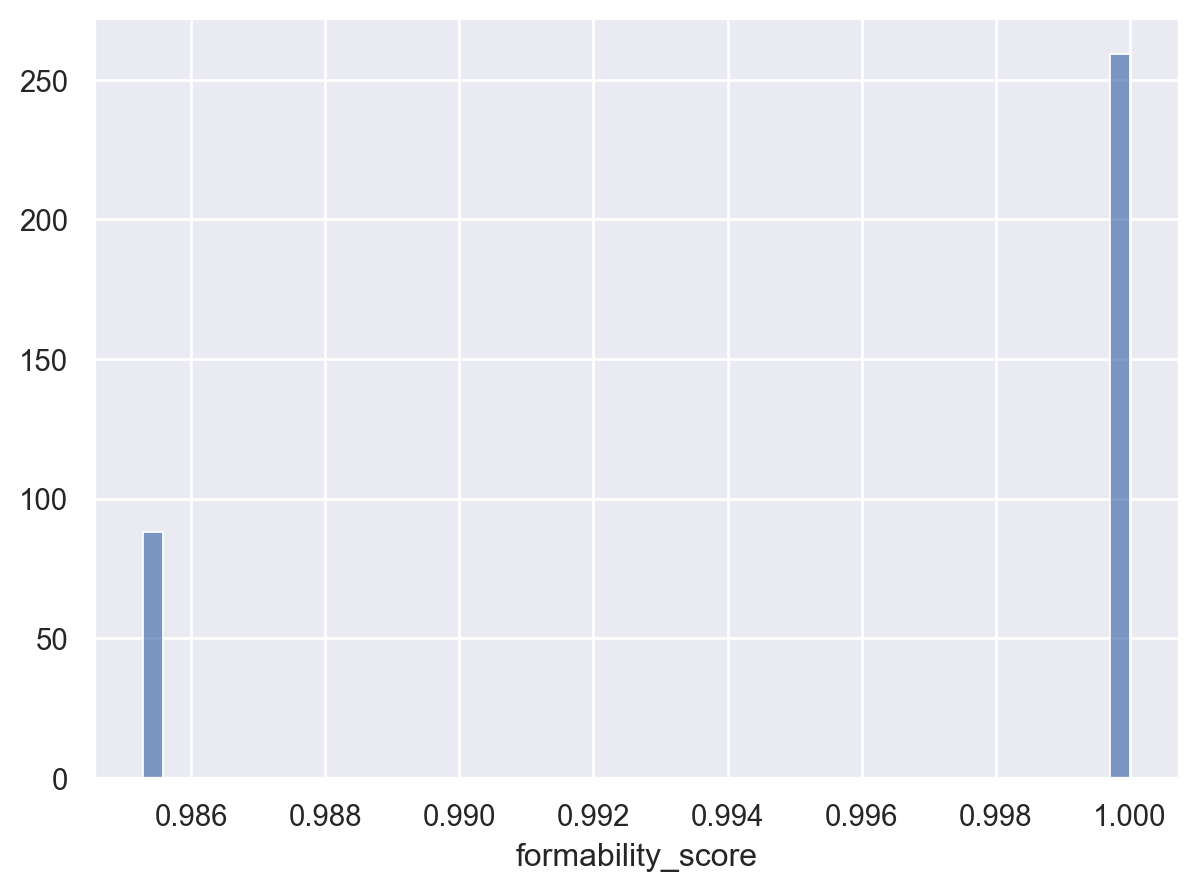

In [56]:
# plot distribution of formability score
import seaborn.objects as so
(
    so.Plot(type_Ib_filtered_dataframe, x='formability_score')
    .add(so.Bars(), so.Hist(bins=50))
)

In [52]:
type_Ib_filtered_dataframe.formability_decision.value_counts()

formability_decision
True    347
Name: count, dtype: int64

In [57]:
type_Ib_filtered_dataframe.to_csv(PROJECT_ROOT_DIRECTORY+'01-rawdata/19-inverse-design/type_Ib/type_Ib_candidates.csv', index=False)

In [63]:
type_Ib_selected_dataframe = type_Ib_filtered_dataframe.query('formability_score >= 0.85').reset_index(drop=True)
print(type_Ib_selected_dataframe.generation.value_counts())
print(len(type_Ib_selected_dataframe.index))

generation
9     95
8     89
10    64
7     51
11    23
6     20
5      5
Name: count, dtype: int64
347


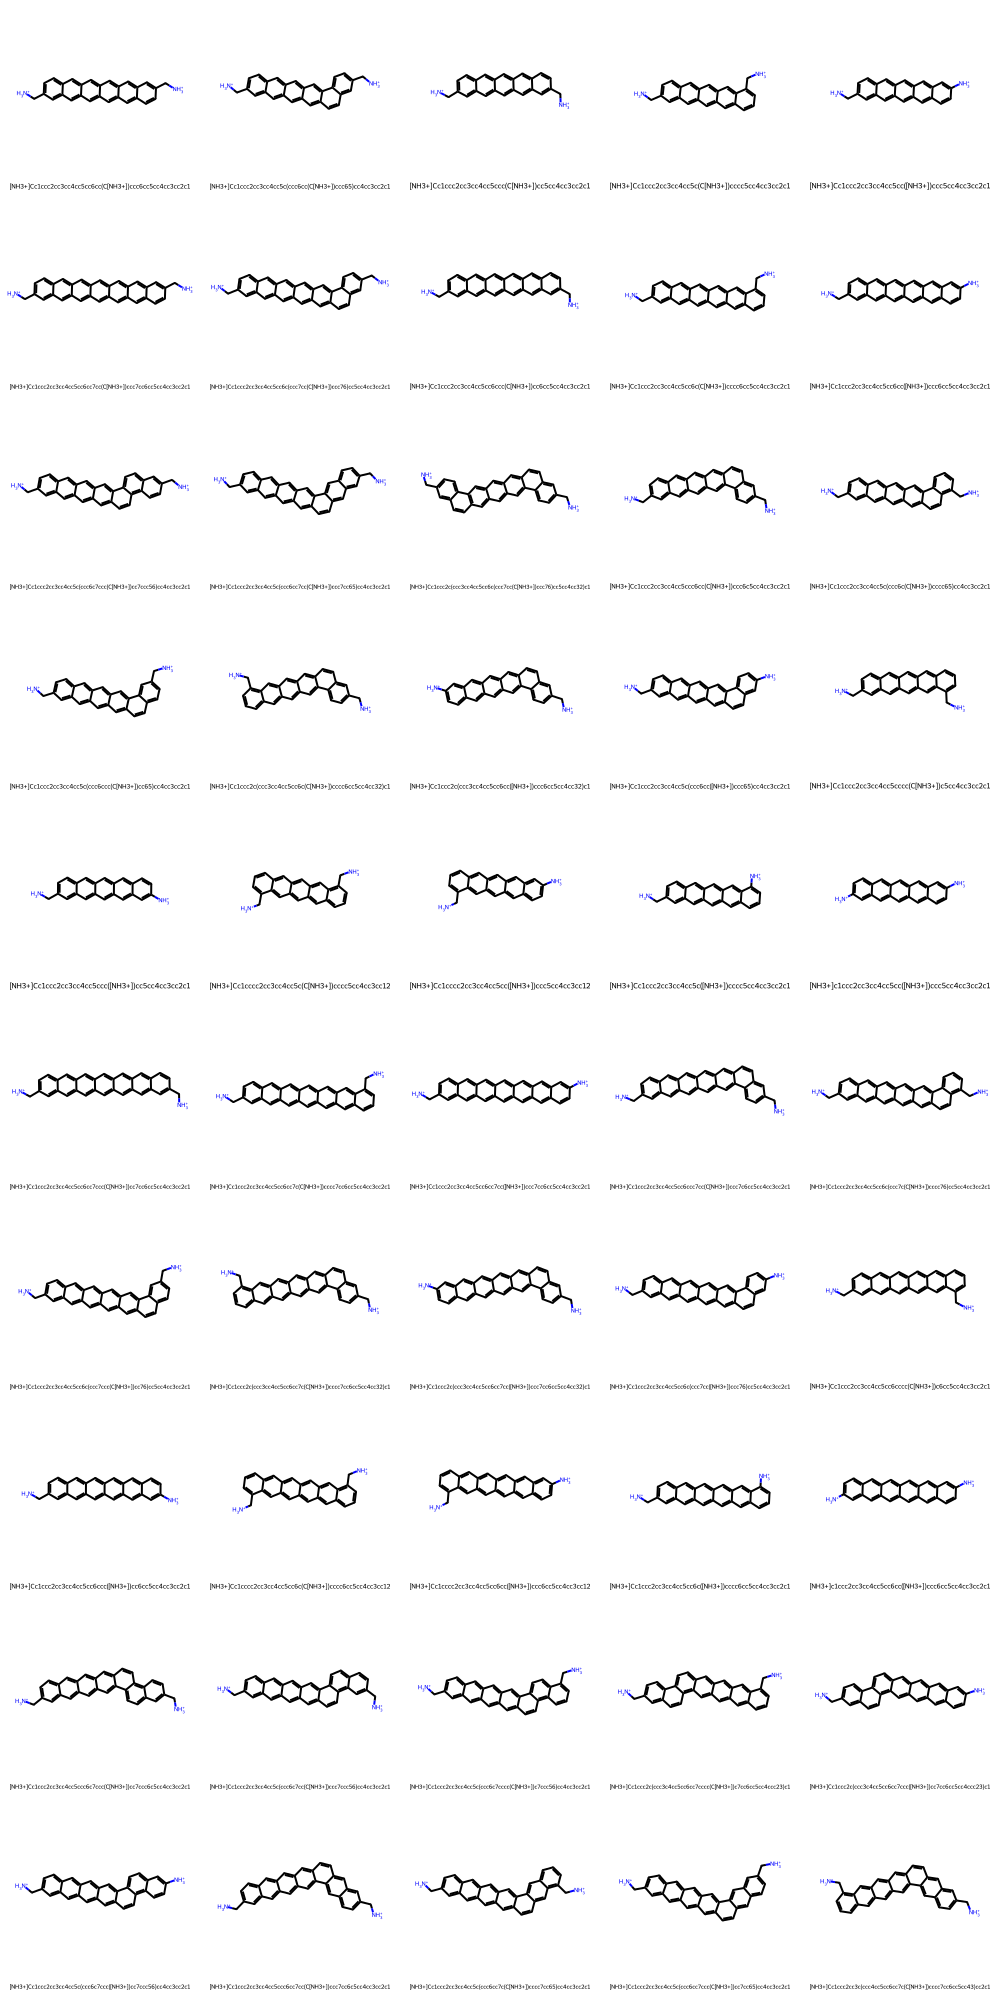

In [59]:
smiles_list = type_Ib_selected_dataframe.smiles_canonical.to_list()
visualize_smiles_list(smiles_list[:50])

In [ ]:
from organic_featurization_helper import get_organic_existence, get_neutral_smiles

for i in type_Ib_selected_dataframe.index:
    smiles_canonical = type_Ib_selected_dataframe.loc[i, 'smiles_canonical']
    smiles_neutral = get_neutral_smiles(smiles_canonical)
                
    # Find the existence of molecule in pubchem
    organic_existence_dict = get_organic_existence(smiles_neutral)
    for key in organic_existence_dict:
        type_Ib_selected_dataframe.loc[i, key] = organic_existence_dict[key]

In [67]:
for index in type_Ib_selected_dataframe.index:
# if cid is integer, then pubchem exsitence is True
    if type_Ib_selected_dataframe.loc[index, 'cid'] is not None:
        type_Ib_selected_dataframe.loc[index, 'PubChem_existence'] = True
    else:
        type_Ib_selected_dataframe.loc[index, 'PubChem_existence'] = False

In [97]:
print(type_Ib_selected_dataframe.PubChem_existence.value_counts())
type_Ib_selected_dataframe.to_csv(PROJECT_ROOT_DIRECTORY+'01-rawdata/19-inverse-design/type_Ib/type_Ib_selected_candidates.csv', index=False)

PubChem_existence
False    344
True       3
Name: count, dtype: int64


In [74]:
type_Ib_final_candidates = type_Ib_selected_dataframe.query('PubChem_existence == True').reset_index(drop=True)
type_Ib_final_candidates = type_Ib_final_candidates.sort_values(by='formability_score', ascending=False)
type_Ib_final_candidates.to_csv(PROJECT_ROOT_DIRECTORY+'01-rawdata/19-inverse-design/type_Ib/type_Ib_synthesizable_candidates.csv', index=False)
type_Ib_final_candidates

smiles_canonical  \
0  [NH3+]c1ccc2cc3cc4cc5ccc([NH3+])cc5cc4cc3cc2c1   
1  [NH3+]c1cccc2cc3cc4cc5c([NH3+])cccc5cc4cc3cc12   
2  [NH3+]c1cccc2cc3cc4cc5cccc([NH3+])c5cc4cc3cc12   

                        Sequence  generation  ringcount  linkage_p  \
0        [6, 6, 6, 6, 8, 11, 11]           7        5.0        0.0   
1     [6, 6, 6, 6, 8, 8, 11, 11]           8        5.0        0.0   
2  [6, 6, 6, 6, 8, 8, 8, 11, 11]           9        5.0        0.0   

   six_ring_p  primaryamine  linker_length  linker_position  hetero_nitrogen  \
0         1.0           2.0            0.0         0.909091              0.0   
1         1.0           2.0            0.0         0.818182              0.0   
2         1.0           2.0            0.0         0.727273              0.0   

   ...  LUMO_prediction  alignment_type_prediction      STEI  NumRot_tail  \
0  ...        -7.150281                         Ib  1.397724          1.0   
1  ...        -7.146814                         Ib  1.449229          1.0   
2  ...        -7.143347                         Ib  1.449477          1.0   

   eccentricity     disNN  formability_score              iupac_name  \
0          12.0  0.006944           0.985303  pentacene-2,10-diamine   
1          11.0  0.008264           0.985302   pentacene-1,8-diamine   
2          11.0  0.010000           0.985294  pentacene-1,11-diamine   

           cid  PubChem_existence  
0   85868421.0               True  
1  154316963.0               True  
2   85868411.0               True  

[3 rows x 26 columns]

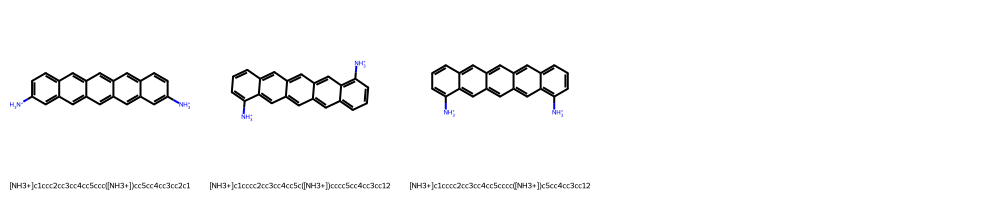

In [76]:
smiles_list = type_Ib_final_candidates.smiles_canonical.to_list()
visualize_smiles_list(smiles_list)

### Type IIa alignment
- selected morphing operator: benzene ring linkage, linker position change, linker length increase/decrease

In [77]:
type_IIa_morphing_operator_index = [5,10,11,14]

In [78]:
starting_mol = Chem.MolFromSmiles('[NH3+]Cc1ccc(C[NH3+])s1')
starting_smiles = Chem.MolToSmiles(starting_mol)
starting_sequence = [1,]

smiles_list = iterative_morphing_operations_to_csv(starting_smiles, starting_sequence, num_iterations=10, 
                                                   output_file_prefix=PROJECT_ROOT_DIRECTORY+'01-rawdata/19-inverse-design/type_IIa_1/smiles',
                                                   selected_morphing_operator_index=type_IIa_morphing_operator_index)

Generation 1 completed. Results saved to /Users/yongxinlyu/OneDrive - UNSW/01-bench/DJperovskite/01-rawdata/19-inverse-design/type_IIa_1/smiles_generation_1.csv
Generation 2 completed. Results saved to /Users/yongxinlyu/OneDrive - UNSW/01-bench/DJperovskite/01-rawdata/19-inverse-design/type_IIa_1/smiles_generation_2.csv
Generation 3 completed. Results saved to /Users/yongxinlyu/OneDrive - UNSW/01-bench/DJperovskite/01-rawdata/19-inverse-design/type_IIa_1/smiles_generation_3.csv
Generation 4 completed. Results saved to /Users/yongxinlyu/OneDrive - UNSW/01-bench/DJperovskite/01-rawdata/19-inverse-design/type_IIa_1/smiles_generation_4.csv
Generation 5 completed. Results saved to /Users/yongxinlyu/OneDrive - UNSW/01-bench/DJperovskite/01-rawdata/19-inverse-design/type_IIa_1/smiles_generation_5.csv
Generation 6 completed. Results saved to /Users/yongxinlyu/OneDrive - UNSW/01-bench/DJperovskite/01-rawdata/19-inverse-design/type_IIa_1/smiles_generation_6.csv
Generation 7 completed. Results sa

In [79]:
# figure out the number of smiles generated in each iteration
import ast
type_IIa_smiles_dataframe = pd.DataFrame()
for i in range(1, 11):
    df = pd.read_csv(PROJECT_ROOT_DIRECTORY+'01-rawdata/19-inverse-design/type_IIa_1/smiles_generation_'+str(i)+'.csv')
    df['generation'] = i+1

    df['Sequence'] = df['Sequence'].apply(ast.literal_eval)
    # Filtering rows
    filtered_df = df[
        df['Sequence'].apply(lambda x: x.count(5) <= 5 and x.count(5) >=1 and x.count(10)-x.count(11) <=4 and x.count(14) <= 2)
    ]
    type_IIa_smiles_dataframe = pd.concat([type_IIa_smiles_dataframe, filtered_df],ignore_index=True)
print(type_IIa_smiles_dataframe['generation'].value_counts().sort_index())

generation
2       1
3       4
4      14
5      28
6      55
7      86
8     128
9     153
10    153
11    122
Name: count, dtype: int64


In [80]:
from organic_featurization_helper import get_organic_structure_descriptors
from utils import predict_mo_lasso, get_alignment_type_prediction
from synthesis_feasibility_helper import calculate_topological_formability_descriptors, calculate_formability_score

for i in type_IIa_smiles_dataframe.index:
    smiles = type_IIa_smiles_dataframe.loc[i, 'smiles_canonical']
    organic_structure_descriptors = get_organic_structure_descriptors(smiles)
    fingerprint_dict = {key: organic_structure_descriptors[key] for key in COLUMNS_DICT['molecular_fingerprint']}
    # Update the dataframe with the new fingerprint values
    for key in fingerprint_dict:
        type_IIa_smiles_dataframe.loc[i, key] = fingerprint_dict[key]

    # predict the energy levels and alignment type
    HOMO_prediction = predict_mo_lasso(fingerprint_dict,target='HOMO')
    LUMO_prediction = predict_mo_lasso(fingerprint_dict,target='LUMO')

    ringcount = fingerprint_dict['ringcount']
    alignment_type_prediction = get_alignment_type_prediction(ringcount, HOMO_prediction, LUMO_prediction)

    type_IIa_smiles_dataframe.loc[i, 'HOMO_prediction'] = HOMO_prediction
    type_IIa_smiles_dataframe.loc[i, 'LUMO_prediction'] = LUMO_prediction
    type_IIa_smiles_dataframe.loc[i, 'alignment_type_prediction'] = alignment_type_prediction

    # formability filter
    mol = Chem.MolFromSmiles(smiles)
    formability_descriptors_dict = calculate_topological_formability_descriptors(mol)

    for key in ['STEI','NumRot_tail','eccentricity','disNN']:
        type_IIa_smiles_dataframe.loc[i, key] = formability_descriptors_dict[key]

    formability_descriptors_dict['linker_position'] = fingerprint_dict['linker_position']
    formability_score_list = calculate_formability_score(formability_descriptors_dict, smearing_factor=0.15)

    type_IIa_smiles_dataframe.loc[i, 'formability_score'] = formability_score_list['formability_score']

type_IIa_smiles_dataframe

smiles_canonical  \
0                    [NH3+]Cc1ccc(-c2ccc(C[NH3+])s2)s1   
1          [NH3+]Cc1ccc(-c2ccc(-c3ccc(C[NH3+])s3)s2)s1   
2                   [NH3+]CCc1ccc(-c2ccc(C[NH3+])s2)s1   
3                     [NH3+]Cc1ccc(-c2ccc([NH3+])s2)s1   
4                 [NH3+]Cc1ccc(-c2ccc(C[NH3+])s2)[nH]1   
..                                                 ...   
739  [NH3+]CCCCCc1ccc(-c2ccc(-c3ccc(-c4ccc([NH3+])s...   
740  [NH3+]CCCCCc1ccc(-c2ccc(-c3ccc(-c4ccc([NH3+])s...   
741  [NH3+]CCCCCCc1ccc(-c2ccc(-c3ccc([NH3+])[nH]3)[...   
742  [NH3+]CCCCCCc1ccc(-c2ccc(-c3ccc([NH3+])[nH]3)s...   
743  [NH3+]CCCCCCc1ccc(-c2ccc(-c3ccc([NH3+])s3)[nH]...   

                                      Sequence  generation  ringcount  \
0                                       [1, 5]           2        2.0   
1                                    [1, 5, 5]           3        3.0   
2                                   [1, 5, 10]           3        2.0   
3                                   [1, 5, 11]           3        2.0   
4                                   [1, 5, 14]           3        2.0   
..                                         ...         ...        ...   
739   [1, 5, 5, 5, 10, 10, 10, 10, 11, 14, 14]          11        4.0   
740   [1, 5, 5, 5, 10, 10, 10, 10, 11, 14, 14]          11        4.0   
741  [1, 5, 5, 10, 10, 10, 10, 10, 11, 14, 14]          11        3.0   
742  [1, 5, 5, 10, 10, 10, 10, 10, 11, 14, 14]          11        3.0   
743  [1, 5, 5, 10, 10, 10, 10, 10, 11, 14, 14]          11        3.0   

     linkage_p  six_ring_p  primaryamine  linker_length  linker_position  \
0          1.0         0.0           2.0            2.0              1.0   
1          1.0         0.0           2.0            2.0              1.0   
2          1.0         0.0           2.0            3.0              1.0   
3          1.0         0.0           2.0            1.0              1.0   
4          1.0         0.0           2.0            2.0              1.0   
..         ...         ...           ...            ...              ...   
739        1.0         0.0           2.0            5.0              1.0   
740        1.0         0.0           2.0            5.0              1.0   
741        1.0         0.0           2.0            6.0              1.0   
742        1.0         0.0           2.0            6.0              1.0   
743        1.0         0.0           2.0            6.0              1.0   

     hetero_nitrogen  ...  sidechain_on_linker  sidechain_on_backbone  \
0                0.0  ...                  0.0                    0.0   
1                0.0  ...                  0.0                    0.0   
2                0.0  ...                  0.0                    0.0   
3                0.0  ...                  0.0                    0.0   
4                0.0  ...                  0.0                    0.0   
..               ...  ...                  ...                    ...   
739              0.0  ...                  0.0                    0.0   
740              0.0  ...                  0.0                    0.0   
741              0.0  ...                  0.0                    0.0   
742              0.0  ...                  0.0                    0.0   
743              0.0  ...                  0.0                    0.0   

     HOMO_prediction  LUMO_prediction  alignment_type_prediction      STEI  \
0         -12.142953        -7.011796                         Ia  1.256739   
1         -10.806522        -6.477755                        IIa  1.261441   
2         -11.616509        -6.506261                         Ia  1.257739   
3         -12.669397        -7.517331                         Ia  1.369827   
4         -11.715665        -6.638439                         Ia  1.256739   
..               ...              ...                        ...       ...   
739        -7.036184        -3.680395                        IIa  1.379919   
740        -7.036184        -3.680395             

In [81]:
type_IIa_smiles_dataframe.alignment_type_prediction.value_counts()

alignment_type_prediction
IIa    719
Ia      24
Ib       1
Name: count, dtype: int64

In [82]:
type_IIa_fingerprint_criteria = 'alignment_type_prediction != "Ia" and ringcount >= 2 and ringcount <= 6 and linkage_p == 1 and six_ring_p == 0 and primaryamine == 2 and linker_length <= 6 and linker_position == 1 and hetero_nitrogen == 0 and fluorination == 0 and furan == 0 and pyrrole <= 2 and sidechain_on_linker == 0 and sidechain_on_backbone == 0'

type_IIa_filtered_dataframe = type_IIa_smiles_dataframe.query(type_IIa_fingerprint_criteria).reset_index(drop=True)

type_IIa_filtered_dataframe

smiles_canonical  \
0          [NH3+]Cc1ccc(-c2ccc(-c3ccc(C[NH3+])s3)s2)s1   
1    [NH3+]Cc1ccc(-c2ccc(-c3ccc(-c4ccc(C[NH3+])s4)s...   
2         [NH3+]CCc1ccc(-c2ccc(-c3ccc(C[NH3+])s3)s2)s1   
3       [NH3+]Cc1ccc(-c2ccc(-c3ccc(C[NH3+])s3)s2)[nH]1   
4       [NH3+]Cc1ccc(-c2ccc(-c3ccc(C[NH3+])s3)[nH]2)s1   
..                                                 ...   
715  [NH3+]CCCCCc1ccc(-c2ccc(-c3ccc(-c4ccc([NH3+])s...   
716  [NH3+]CCCCCc1ccc(-c2ccc(-c3ccc(-c4ccc([NH3+])s...   
717  [NH3+]CCCCCCc1ccc(-c2ccc(-c3ccc([NH3+])[nH]3)[...   
718  [NH3+]CCCCCCc1ccc(-c2ccc(-c3ccc([NH3+])[nH]3)s...   
719  [NH3+]CCCCCCc1ccc(-c2ccc(-c3ccc([NH3+])s3)[nH]...   

                                      Sequence  generation  ringcount  \
0                                    [1, 5, 5]           3        3.0   
1                                 [1, 5, 5, 5]           4        4.0   
2                                [1, 5, 5, 10]           4        3.0   
3                                [1, 5, 5, 14]           4        3.0   
4                                [1, 5, 5, 14]           4        3.0   
..                                         ...         ...        ...   
715   [1, 5, 5, 5, 10, 10, 10, 10, 11, 14, 14]          11        4.0   
716   [1, 5, 5, 5, 10, 10, 10, 10, 11, 14, 14]          11        4.0   
717  [1, 5, 5, 10, 10, 10, 10, 10, 11, 14, 14]          11        3.0   
718  [1, 5, 5, 10, 10, 10, 10, 10, 11, 14, 14]          11        3.0   
719  [1, 5, 5, 10, 10, 10, 10, 10, 11, 14, 14]          11        3.0   

     linkage_p  six_ring_p  primaryamine  linker_length  linker_position  \
0          1.0         0.0           2.0            2.0              1.0   
1          1.0         0.0           2.0            2.0              1.0   
2          1.0         0.0           2.0            3.0              1.0   
3          1.0         0.0           2.0            2.0              1.0   
4          1.0         0.0           2.0            2.0              1.0   
..         ...         ...           ...            ...              ...   
715        1.0         0.0           2.0            5.0              1.0   
716        1.0         0.0           2.0            5.0              1.0   
717        1.0         0.0           2.0            6.0              1.0   
718        1.0         0.0           2.0            6.0              1.0   
719        1.0         0.0           2.0            6.0              1.0   

     hetero_nitrogen  ...  sidechain_on_linker  sidechain_on_backbone  \
0                0.0  ...                  0.0                    0.0   
1                0.0  ...                  0.0                    0.0   
2                0.0  ...                  0.0                    0.0   
3                0.0  ...                  0.0                    0.0   
4                0.0  ...                  0.0                    0.0   
..               ...  ...                  ...                    ...   
715              0.0  ...                  0.0                    0.0   
716              0.0  ...                  0.0                    0.0   
717              0.0  ...                  0.0                    0.0   
718              0.0  ...                  0.0                    0.0   
719              0.0  ...                  0.0                    0.0   

     HOMO_prediction  LUMO_prediction  alignment_type_prediction      STEI  \
0         -10.806522        -6.477755                        IIa  1.261441   
1          -9.470092        -5.943714                        IIa  1.263591   
2         -10.280078        -5.972220                        IIa  1.261896   
3         -10.379235        -6.104398                        IIa  1.261441   
4         -10.379235        -6.104398                        IIa  1.261441   
..               ...              ...                        ...       ...   
715        -7.036184        -3.680395                        IIa  1.379919   
716        -7.036184        -3.680395             

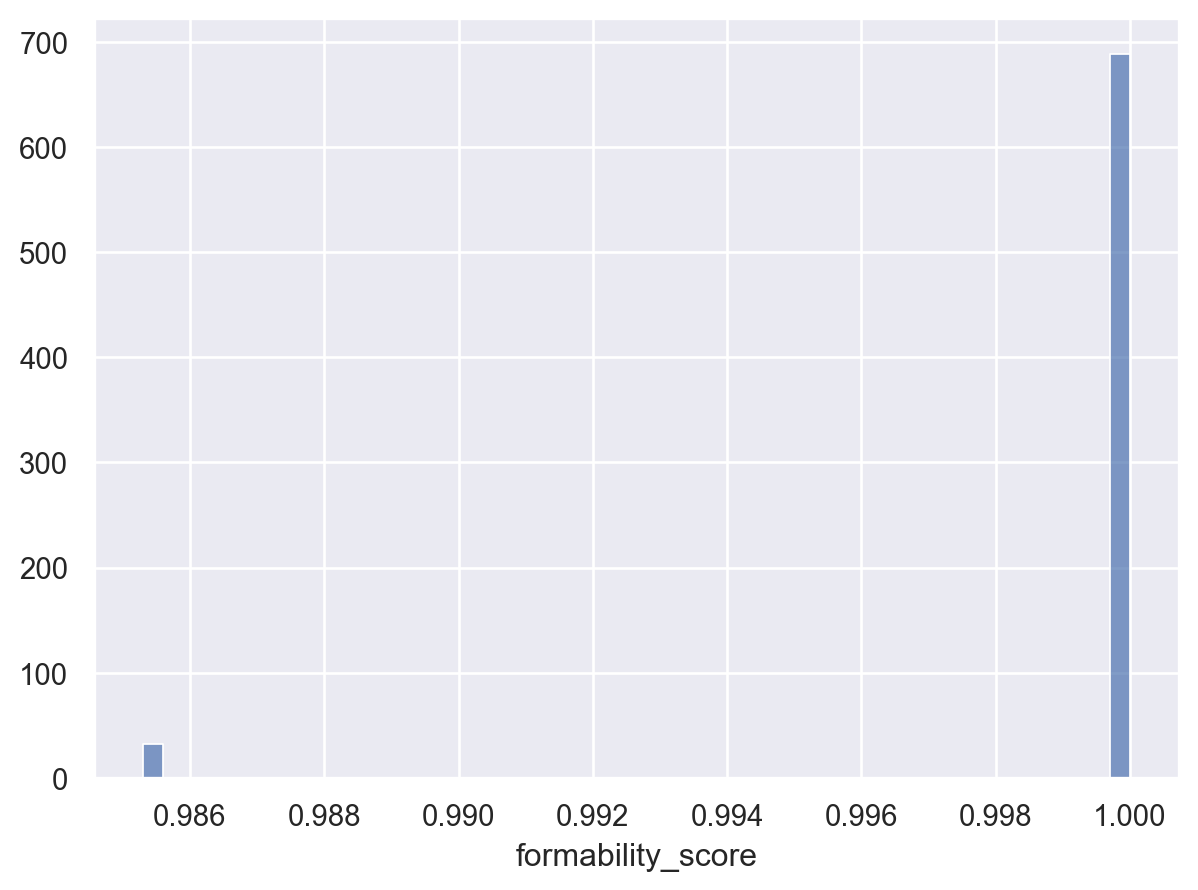

In [83]:
type_IIa_filtered_dataframe.to_csv(PROJECT_ROOT_DIRECTORY+'01-rawdata/19-inverse-design/type_IIa_1/type_IIa_candidates.csv', index=False)
(
    so.Plot(type_IIa_filtered_dataframe, x='formability_score')
    .add(so.Bars(), so.Hist(bins=50))
)

In [84]:
type_IIa_selected_dataframe = type_IIa_filtered_dataframe.query('formability_score >= 0.85').reset_index(drop=True)
print(type_IIa_selected_dataframe.generation.value_counts())
print(len(type_IIa_selected_dataframe.index))

generation
9     153
10    153
8     128
11    122
7      86
6      49
5      22
4       6
3       1
Name: count, dtype: int64
720


In [85]:
known_dataframe = pd.read_csv(PROJECT_ROOT_DIRECTORY + '01-rawdata/19-final-candidates/type_IIa/type_IIa_selected_candidates.csv')
known_dataframe

smiles_canonical  \
0          [NH3+]Cc1ccc(-c2ccc(-c3ccc(C[NH3+])s3)s2)s1   
1    [NH3+]Cc1ccc(-c2ccc(-c3ccc(-c4ccc(C[NH3+])s4)s...   
2         [NH3+]CCc1ccc(-c2ccc(-c3ccc(C[NH3+])s3)s2)s1   
3       [NH3+]Cc1ccc(-c2ccc(-c3ccc(C[NH3+])s3)s2)[nH]1   
4       [NH3+]Cc1ccc(-c2ccc(-c3ccc(C[NH3+])s3)[nH]2)s1   
..                                                 ...   
715  [NH3+]CCCCCc1ccc(-c2ccc(-c3ccc(-c4ccc([NH3+])s...   
716  [NH3+]CCCCCc1ccc(-c2ccc(-c3ccc(-c4ccc([NH3+])s...   
717  [NH3+]CCCCCCc1ccc(-c2ccc(-c3ccc([NH3+])[nH]3)[...   
718  [NH3+]CCCCCCc1ccc(-c2ccc(-c3ccc([NH3+])[nH]3)s...   
719  [NH3+]CCCCCCc1ccc(-c2ccc(-c3ccc([NH3+])s3)[nH]...   

                                      Sequence  generation  ringcount  \
0                                    [1, 5, 5]           3        3.0   
1                                 [1, 5, 5, 5]           4        4.0   
2                                [1, 5, 5, 10]           4        3.0   
3                                [1, 5, 5, 14]           4        3.0   
4                                [1, 5, 5, 14]           4        3.0   
..                                         ...         ...        ...   
715   [1, 5, 5, 5, 10, 10, 10, 10, 11, 14, 14]          11        4.0   
716   [1, 5, 5, 5, 10, 10, 10, 10, 11, 14, 14]          11        4.0   
717  [1, 5, 5, 10, 10, 10, 10, 10, 11, 14, 14]          11        3.0   
718  [1, 5, 5, 10, 10, 10, 10, 10, 11, 14, 14]          11        3.0   
719  [1, 5, 5, 10, 10, 10, 10, 10, 11, 14, 14]          11        3.0   

     linkage_p  six_ring_p  primaryamine  linker_length  linker_position  \
0          1.0         0.0           2.0            2.0              1.0   
1          1.0         0.0           2.0            2.0              1.0   
2          1.0         0.0           2.0            3.0              1.0   
3          1.0         0.0           2.0            2.0              1.0   
4          1.0         0.0           2.0            2.0              1.0   
..         ...         ...           ...            ...              ...   
715        1.0         0.0           2.0            5.0              1.0   
716        1.0         0.0           2.0            5.0              1.0   
717        1.0         0.0           2.0            6.0              1.0   
718        1.0         0.0           2.0            6.0              1.0   
719        1.0         0.0           2.0            6.0              1.0   

     hetero_nitrogen  ...  NumN  STEI_decision  NumRot_tail_decision  \
0                0.0  ...   2.0           True                  True   
1                0.0  ...   2.0           True                  True   
2                0.0  ...   2.0           True                  True   
3                0.0  ...   2.0           True                  True   
4                0.0  ...   2.0           True                  True   
..               ...  ...   ...            ...                   ...   
715              0.0  ...   2.0           True                  True   
716              0.0  ...   2.0           True                  True   
717              0.0  ...   2.0           True                  True   
718              0.0  ...   2.0           True                  True   
719              0.0  ...   2.0           True                  True   

     eccentricity_decision  disNN_decision  formability_decision  \
0                     True            True                  True   
1                     True            True                  True   
2                     True            True                  True   
3                     True            True                  True   
4                     True            True                  True   
..                     ...             ...                   ...   
715                   True            True                  True   
716                   True            True                  True   
717                   True            True                  True   
718   

In [88]:
type_IIa_selected_dataframe_new = pd.merge(type_IIa_selected_dataframe, known_dataframe[['smiles_canonical','iupac_name','cid']], how='left', on='smiles_canonical')
type_IIa_selected_dataframe_new

smiles_canonical  \
0          [NH3+]Cc1ccc(-c2ccc(-c3ccc(C[NH3+])s3)s2)s1   
1    [NH3+]Cc1ccc(-c2ccc(-c3ccc(-c4ccc(C[NH3+])s4)s...   
2         [NH3+]CCc1ccc(-c2ccc(-c3ccc(C[NH3+])s3)s2)s1   
3       [NH3+]Cc1ccc(-c2ccc(-c3ccc(C[NH3+])s3)s2)[nH]1   
4       [NH3+]Cc1ccc(-c2ccc(-c3ccc(C[NH3+])s3)[nH]2)s1   
..                                                 ...   
715  [NH3+]CCCCCc1ccc(-c2ccc(-c3ccc(-c4ccc([NH3+])s...   
716  [NH3+]CCCCCc1ccc(-c2ccc(-c3ccc(-c4ccc([NH3+])s...   
717  [NH3+]CCCCCCc1ccc(-c2ccc(-c3ccc([NH3+])[nH]3)[...   
718  [NH3+]CCCCCCc1ccc(-c2ccc(-c3ccc([NH3+])[nH]3)s...   
719  [NH3+]CCCCCCc1ccc(-c2ccc(-c3ccc([NH3+])s3)[nH]...   

                                      Sequence  generation  ringcount  \
0                                    [1, 5, 5]           3        3.0   
1                                 [1, 5, 5, 5]           4        4.0   
2                                [1, 5, 5, 10]           4        3.0   
3                                [1, 5, 5, 14]           4        3.0   
4                                [1, 5, 5, 14]           4        3.0   
..                                         ...         ...        ...   
715   [1, 5, 5, 5, 10, 10, 10, 10, 11, 14, 14]          11        4.0   
716   [1, 5, 5, 5, 10, 10, 10, 10, 11, 14, 14]          11        4.0   
717  [1, 5, 5, 10, 10, 10, 10, 10, 11, 14, 14]          11        3.0   
718  [1, 5, 5, 10, 10, 10, 10, 10, 11, 14, 14]          11        3.0   
719  [1, 5, 5, 10, 10, 10, 10, 10, 11, 14, 14]          11        3.0   

     linkage_p  six_ring_p  primaryamine  linker_length  linker_position  \
0          1.0         0.0           2.0            2.0              1.0   
1          1.0         0.0           2.0            2.0              1.0   
2          1.0         0.0           2.0            3.0              1.0   
3          1.0         0.0           2.0            2.0              1.0   
4          1.0         0.0           2.0            2.0              1.0   
..         ...         ...           ...            ...              ...   
715        1.0         0.0           2.0            5.0              1.0   
716        1.0         0.0           2.0            5.0              1.0   
717        1.0         0.0           2.0            6.0              1.0   
718        1.0         0.0           2.0            6.0              1.0   
719        1.0         0.0           2.0            6.0              1.0   

     hetero_nitrogen  ...  HOMO_prediction  LUMO_prediction  \
0                0.0  ...       -10.806522        -6.477755   
1                0.0  ...        -9.470092        -5.943714   
2                0.0  ...       -10.280078        -5.972220   
3                0.0  ...       -10.379235        -6.104398   
4                0.0  ...       -10.379235        -6.104398   
..               ...  ...              ...              ...   
715              0.0  ...        -7.036184        -3.680395   
716              0.0  ...        -7.036184        -3.680395   
717              0.0  ...        -7.846170        -3.708901   
718              0.0  ...        -7.846170        -3.708901   
719              0.0  ...        -7.846170        -3.708901   

     alignment_type_prediction      STEI  NumRot_tail  eccentricity     disNN  \
0                          IIa  1.261441          2.0          12.0  0.006944   
1                          IIa  1.263591          2.0          15.0  0.004444   
2                          IIa  1.261896          2.5          13.0  0.005917   
3                          IIa  1.261441          2.0          12.0  0.006944   
4                          IIa  1.261441          2.0          12.0  0.006944   
..                         ...       ...          ...           ...       ...   
715                        IIa  1.379919          3.5          18.0  0.003086   
716                        IIa  1.379919          3.5          18.0  0.003086   
717                        IIa  1.378214          4.0          16

In [90]:
type_IIa_selected_dataframe = type_IIa_selected_dataframe_new.copy()

In [103]:
from organic_featurization_helper import get_organic_existence, get_neutral_smiles

for i in type_IIa_selected_dataframe.index:
    smiles_canonical = type_IIa_selected_dataframe.loc[i, 'smiles_canonical']
    smiles_neutral = get_neutral_smiles(smiles_canonical)
                
    # Find the existence of molecule in pubchem
    organic_existence_dict = get_organic_existence(smiles_neutral)
    for key in organic_existence_dict:
        type_IIa_selected_dataframe.loc[i, key] = organic_existence_dict[key]

In [91]:
for index in type_IIa_selected_dataframe.index:
# if cid is integer, then pubchem exsitence is True
    if type_IIa_selected_dataframe.loc[index, 'cid'] >0 :
        type_IIa_selected_dataframe.loc[index, 'PubChem_existence'] = True
    else:
        type_IIa_selected_dataframe.loc[index, 'PubChem_existence'] = False

In [93]:
type_IIa_selected_dataframe.to_csv(PROJECT_ROOT_DIRECTORY+'01-rawdata/19-inverse-design/type_IIa_1/type_IIa_selected_candidates.csv', index=False)
type_IIa_selected_dataframe.PubChem_existence.value_counts()

PubChem_existence
False    708
True      12
Name: count, dtype: int64

In [94]:
type_IIa_final_candidates = type_IIa_selected_dataframe.query('PubChem_existence == True').reset_index(drop=True)
print(type_IIa_final_candidates.generation.value_counts().sort_index())
type_IIa_final_candidates = type_IIa_final_candidates.sort_values(by='formability_score', ascending=False)
type_IIa_final_candidates.to_csv(PROJECT_ROOT_DIRECTORY+'01-rawdata/19-inverse-design/type_IIa_1/type_IIa_synthesizable_candidates.csv', index=False)

generation
3    1
4    2
5    2
6    3
7    2
8    1
9    1
Name: count, dtype: int64


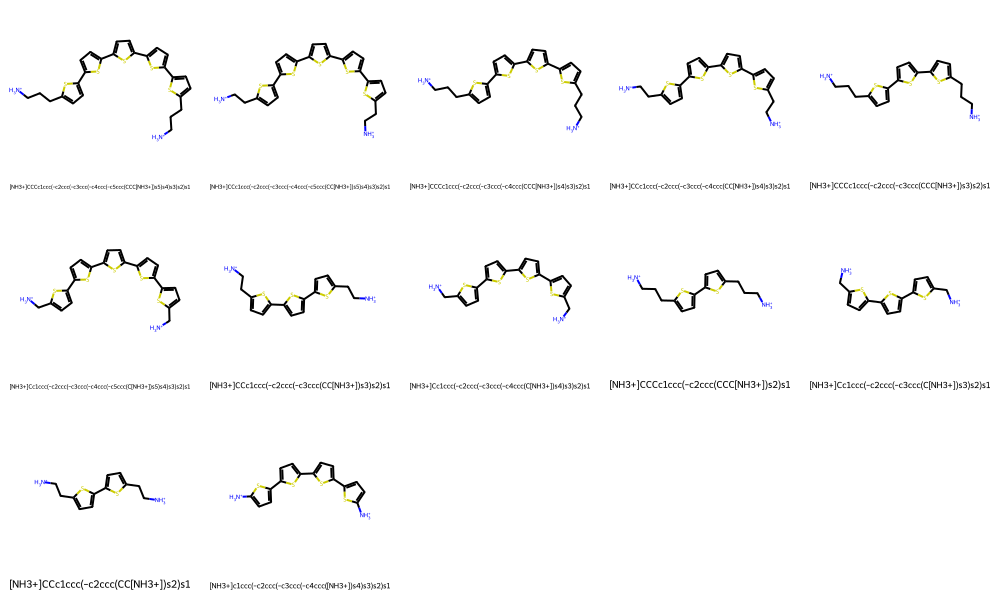

In [95]:
from utils import visualize_smiles_list

smiles_list = type_IIa_final_candidates.smiles_canonical.to_list()
visualize_smiles_list(smiles_list)

### Type IIa aligment - set 2

In [100]:
type_IIa_morphing_operator_index = [6,10,11]

In [101]:
starting_mol = Chem.MolFromSmiles('[NH3+]Cc1ccc(C[NH3+])cc1')
starting_smiles = Chem.MolToSmiles(starting_mol)
starting_sequence = []

smiles_list = iterative_morphing_operations_to_csv(starting_smiles, starting_sequence, num_iterations=10, 
                                                   output_file_prefix=PROJECT_ROOT_DIRECTORY+'01-rawdata/19-inverse-design/type_IIa_2/smiles',
                                                   selected_morphing_operator_index=type_IIa_morphing_operator_index)

Generation 1 completed. Results saved to /Users/yongxinlyu/OneDrive - UNSW/01-bench/DJperovskite/01-rawdata/19-inverse-design/type_IIa_2/smiles_generation_1.csv
Generation 2 completed. Results saved to /Users/yongxinlyu/OneDrive - UNSW/01-bench/DJperovskite/01-rawdata/19-inverse-design/type_IIa_2/smiles_generation_2.csv
Generation 3 completed. Results saved to /Users/yongxinlyu/OneDrive - UNSW/01-bench/DJperovskite/01-rawdata/19-inverse-design/type_IIa_2/smiles_generation_3.csv
Generation 4 completed. Results saved to /Users/yongxinlyu/OneDrive - UNSW/01-bench/DJperovskite/01-rawdata/19-inverse-design/type_IIa_2/smiles_generation_4.csv
Generation 5 completed. Results saved to /Users/yongxinlyu/OneDrive - UNSW/01-bench/DJperovskite/01-rawdata/19-inverse-design/type_IIa_2/smiles_generation_5.csv
Generation 6 completed. Results saved to /Users/yongxinlyu/OneDrive - UNSW/01-bench/DJperovskite/01-rawdata/19-inverse-design/type_IIa_2/smiles_generation_6.csv
Generation 7 completed. Results sa

In [102]:
# figure out the number of smiles generated in each iteration
import ast
type_IIa_smiles_dataframe = pd.DataFrame()
for i in range(1, 11):
    df = pd.read_csv(PROJECT_ROOT_DIRECTORY+'01-rawdata/19-inverse-design/type_IIa_2/smiles_generation_'+str(i)+'.csv')
    df['generation'] = i

    df['Sequence'] = df['Sequence'].apply(ast.literal_eval)
    # Filtering rows
    filtered_df = df[
        df['Sequence'].apply(lambda x: x.count(6) <= 3 and x.count(6) >=1 and x.count(10)-x.count(11) <=4)
    ]
    type_IIa_smiles_dataframe = pd.concat([type_IIa_smiles_dataframe, filtered_df],ignore_index=True)
print(type_IIa_smiles_dataframe['generation'].value_counts().sort_index())

generation
1     1
2     4
3    11
4    19
5    24
6    21
7    18
8     6
9     4
Name: count, dtype: int64


In [103]:
from organic_featurization_helper import get_organic_structure_descriptors
from utils import predict_mo_lasso, get_alignment_type_prediction
from synthesis_feasibility_helper import calculate_topological_formability_descriptors, calculate_formability_score

for i in type_IIa_smiles_dataframe.index:
    smiles = type_IIa_smiles_dataframe.loc[i, 'smiles_canonical']
    organic_structure_descriptors = get_organic_structure_descriptors(smiles)
    fingerprint_dict = {key: organic_structure_descriptors[key] for key in COLUMNS_DICT['molecular_fingerprint']}
    # Update the dataframe with the new fingerprint values
    for key in fingerprint_dict:
        type_IIa_smiles_dataframe.loc[i, key] = fingerprint_dict[key]

    # predict the energy levels and alignment type
    HOMO_prediction = predict_mo_lasso(fingerprint_dict,target='HOMO')
    LUMO_prediction = predict_mo_lasso(fingerprint_dict,target='LUMO')

    ringcount = fingerprint_dict['ringcount']
    alignment_type_prediction = get_alignment_type_prediction(ringcount, HOMO_prediction, LUMO_prediction)

    type_IIa_smiles_dataframe.loc[i, 'HOMO_prediction'] = HOMO_prediction
    type_IIa_smiles_dataframe.loc[i, 'LUMO_prediction'] = LUMO_prediction
    type_IIa_smiles_dataframe.loc[i, 'alignment_type_prediction'] = alignment_type_prediction

    # formability filter
    mol = Chem.MolFromSmiles(smiles)
    formability_descriptors_dict = calculate_topological_formability_descriptors(mol)

    for key in ['STEI','NumRot_tail','eccentricity','disNN']:
        type_IIa_smiles_dataframe.loc[i, key] = formability_descriptors_dict[key]

    formability_descriptors_dict['linker_position'] = fingerprint_dict['linker_position']
    formability_score_list = calculate_formability_score(formability_descriptors_dict, smearing_factor=0.15)

    type_IIa_smiles_dataframe.loc[i, 'formability_score'] = formability_score_list['formability_score']

type_IIa_smiles_dataframe

smiles_canonical  \
0                      [NH3+]Cc1ccc2cc(C[NH3+])ccc2c1   
1                [NH3+]Cc1ccc2cc3cc(C[NH3+])ccc3cc2c1   
2              [NH3+]Cc1ccc2c(ccc3cc(C[NH3+])ccc32)c1   
3                     [NH3+]CCc1ccc2cc(C[NH3+])ccc2c1   
4                       [NH3+]Cc1ccc2cc([NH3+])ccc2c1   
..                                                ...   
103        [NH3+]CCCCCCc1ccc2c(ccc3cc([NH3+])ccc32)c1   
104    [NH3+]CCCCCCc1ccc2cc3cc4cc([NH3+])ccc4cc3cc2c1   
105  [NH3+]CCCCCCc1ccc2cc3c(ccc4cc([NH3+])ccc43)cc2c1   
106  [NH3+]CCCCCCc1ccc2c(ccc3cc4cc([NH3+])ccc4cc32)c1   
107  [NH3+]CCCCCCc1ccc2c(ccc3c4ccc([NH3+])cc4ccc23)c1   

                              Sequence  generation  ringcount  linkage_p  \
0                                  [6]           1        2.0        0.0   
1                               [6, 6]           2        3.0        0.0   
2                               [6, 6]           2        3.0        0.0   
3                              [6, 10]           2        2.0        0.0   
4                              [6, 11]           2        2.0        0.0   
..                                 ...         ...        ...        ...   
103     [6, 6, 10, 10, 10, 10, 10, 11]           8        3.0        0.0   
104  [6, 6, 6, 10, 10, 10, 10, 10, 11]           9        4.0        0.0   
105  [6, 6, 6, 10, 10, 10, 10, 10, 11]           9        4.0        0.0   
106  [6, 6, 6, 10, 10, 10, 10, 10, 11]           9        4.0        0.0   
107  [6, 6, 6, 10, 10, 10, 10, 10, 11]           9        4.0        0.0   

     six_ring_p  primaryamine  linker_length  linker_position  \
0           1.0           2.0            2.0              1.0   
1           1.0           2.0            2.0              1.0   
2           1.0           2.0            2.0              1.0   
3           1.0           2.0            3.0              1.0   
4           1.0           2.0            1.0              1.0   
..          ...           ...            ...              ...   
103         1.0           2.0            6.0              1.0   
104         1.0           2.0            6.0              1.0   
105         1.0           2.0            6.0              1.0   
106         1.0           2.0            6.0              1.0   
107         1.0           2.0            6.0              1.0   

     hetero_nitrogen  ...  sidechain_on_linker  sidechain_on_backbone  \
0                0.0  ...                  0.0                    0.0   
1                0.0  ...                  0.0                    0.0   
2                0.0  ...                  0.0                    0.0   
3                0.0  ...                  0.0                    0.0   
4                0.0  ...                  0.0                    0.0   
..               ...  ...                  ...                    ...   
103              0.0  ...                  0.0                    0.0   
104              0.0  ...                  0.0                    0.0   
105              0.0  ...                  0.0                    0.0   
106              0.0  ...                  0.0                    0.0   
107              0.0  ...                  0.0                    0.0   

     HOMO_prediction  LUMO_prediction  alignment_type_prediction      STEI  \
0         -12.725122        -7.744801                         Ia  1.261824   
1         -11.388692        -7.210760                         Ia  1.268444   
2         -11.388692        -7.210760                         Ia  1.268444   
3         -12.198678        -7.239267                         Ia  1.262824   
4         -13.251566        -8.250336                         Ia  1.380822   
..               ...              ...                        ...       ...   
103        -9.282915        -5.188621                        IIa  1.393185   
104        -7.946485        -4.654580                        IIa  1.396958   
105        -7.946485        -4.654580                        IIa  1.396958   
1

In [105]:
print(type_IIa_smiles_dataframe.alignment_type_prediction.value_counts())

alignment_type_prediction
IIa    85
Ia     20
IIb     3
Name: count, dtype: int64


In [106]:
type_IIa_fingerprint_criteria = 'alignment_type_prediction != "Ia" and ringcount >= 2 and ringcount <= 4 and linkage_p == 0 and six_ring_p == 1 and primaryamine == 2 and linker_length <= 6 and linker_position == 1 and hetero_nitrogen == 0 and fluorination == 0 and furan == 0 and pyrrole == 0 and sidechain_on_linker == 0 and sidechain_on_backbone == 0'

type_IIa_filtered_dataframe = type_IIa_smiles_dataframe.query(type_IIa_fingerprint_criteria).reset_index(drop=True)

type_IIa_filtered_dataframe

smiles_canonical  \
0         [NH3+]Cc1ccc2cc3cc4cc(C[NH3+])ccc4cc3cc2c1   
1       [NH3+]Cc1ccc2cc3c(ccc4cc(C[NH3+])ccc43)cc2c1   
2              [NH3+]CCc1ccc2cc3cc(C[NH3+])ccc3cc2c1   
3       [NH3+]Cc1ccc2c(ccc3c4ccc(C[NH3+])cc4ccc23)c1   
4            [NH3+]CCc1ccc2c(ccc3cc(C[NH3+])ccc32)c1   
..                                               ...   
83        [NH3+]CCCCCCc1ccc2c(ccc3cc([NH3+])ccc32)c1   
84    [NH3+]CCCCCCc1ccc2cc3cc4cc([NH3+])ccc4cc3cc2c1   
85  [NH3+]CCCCCCc1ccc2cc3c(ccc4cc([NH3+])ccc43)cc2c1   
86  [NH3+]CCCCCCc1ccc2c(ccc3cc4cc([NH3+])ccc4cc32)c1   
87  [NH3+]CCCCCCc1ccc2c(ccc3c4ccc([NH3+])cc4ccc23)c1   

                             Sequence  generation  ringcount  linkage_p  \
0                           [6, 6, 6]           3        4.0        0.0   
1                           [6, 6, 6]           3        4.0        0.0   
2                          [6, 6, 10]           3        3.0        0.0   
3                           [6, 6, 6]           3        4.0        0.0   
4                          [6, 6, 10]           3        3.0        0.0   
..                                ...         ...        ...        ...   
83     [6, 6, 10, 10, 10, 10, 10, 11]           8        3.0        0.0   
84  [6, 6, 6, 10, 10, 10, 10, 10, 11]           9        4.0        0.0   
85  [6, 6, 6, 10, 10, 10, 10, 10, 11]           9        4.0        0.0   
86  [6, 6, 6, 10, 10, 10, 10, 10, 11]           9        4.0        0.0   
87  [6, 6, 6, 10, 10, 10, 10, 10, 11]           9        4.0        0.0   

    six_ring_p  primaryamine  linker_length  linker_position  hetero_nitrogen  \
0          1.0           2.0            2.0              1.0              0.0   
1          1.0           2.0            2.0              1.0              0.0   
2          1.0           2.0            3.0              1.0              0.0   
3          1.0           2.0            2.0              1.0              0.0   
4          1.0           2.0            3.0              1.0              0.0   
..         ...           ...            ...              ...              ...   
83         1.0           2.0            6.0              1.0              0.0   
84         1.0           2.0            6.0              1.0              0.0   
85         1.0           2.0            6.0              1.0              0.0   
86         1.0           2.0            6.0              1.0              0.0   
87         1.0           2.0            6.0              1.0              0.0   

    ...  sidechain_on_linker  sidechain_on_backbone  HOMO_prediction  \
0   ...                  0.0                    0.0       -10.052261   
1   ...                  0.0                    0.0       -10.052261   
2   ...                  0.0                    0.0       -10.862248   
3   ...                  0.0                    0.0       -10.052261   
4   ...                  0.0                    0.0       -10.862248   
..  ...                  ...                    ...              ...   
83  ...                  0.0                    0.0        -9.282915   
84  ...                  0.0                    0.0        -7.946485   
85  ...                  0.0                    0.0        -7.946485   
86  ...                  0.0                    0.0        -7.946485   
87  ...                  0.0                    0.0        -7.946485   

    LUMO_prediction  alignment_type_prediction      STEI  NumRot_tail  \
0         -6.676719                        IIa  1.271849          2.0   
1         -6.676719                        IIa  1.271849          2.0   
2         -6.705226                        IIa  1.269022          2.5   
3         -6.676719                        IIa  1.271849          2.0   
4         -6.705226                        IIa  1.269022          2.5   
..              ...                        ...       ...          ...   
83        -5.188621                        IIa  1.393185          4.0   
84        -4.654580                     

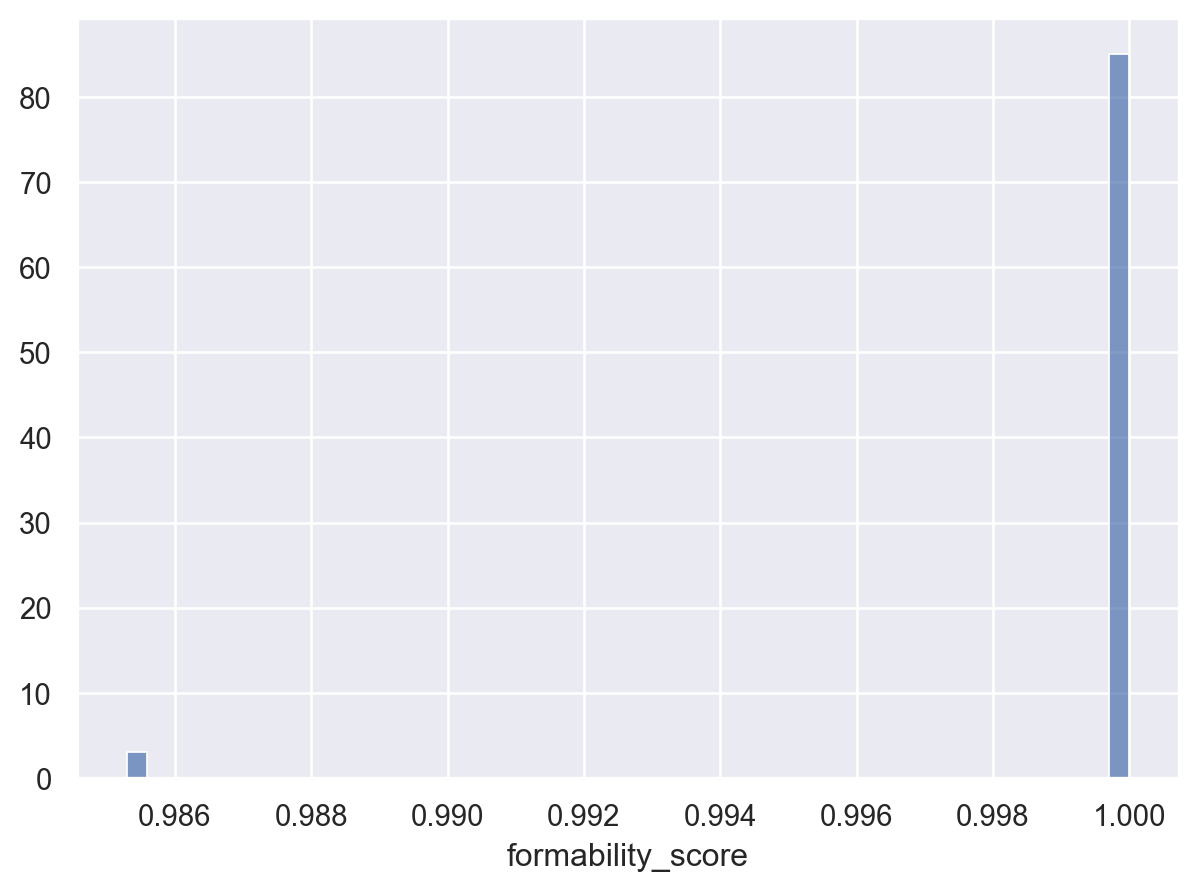

In [107]:
type_IIa_filtered_dataframe.to_csv(PROJECT_ROOT_DIRECTORY+'01-rawdata/19-inverse-design/type_IIa_2/type_IIa_candidates.csv', index=False)
(
    so.Plot(type_IIa_filtered_dataframe, x='formability_score')
    .add(so.Bars(), so.Hist(bins=50))
)

In [108]:
type_IIa_selected_dataframe = type_IIa_filtered_dataframe.query('formability_score >= 0.85').reset_index(drop=True)
print(type_IIa_selected_dataframe.generation.value_counts())
print(len(type_IIa_selected_dataframe.index))

generation
5    23
6    20
7    18
4    12
8     6
3     5
9     4
Name: count, dtype: int64
88


In [109]:
from organic_featurization_helper import get_organic_existence, get_neutral_smiles

for i in type_IIa_selected_dataframe.index:
    smiles_canonical = type_IIa_selected_dataframe.loc[i, 'smiles_canonical']
    smiles_neutral = get_neutral_smiles(smiles_canonical)
                
    # Find the existence of molecule in pubchem
    organic_existence_dict = get_organic_existence(smiles_neutral)
    for key in organic_existence_dict:
        type_IIa_selected_dataframe.loc[i, key] = organic_existence_dict[key]

In [110]:
for index in type_IIa_selected_dataframe.index:
# if cid is integer, then pubchem exsitence is True
    if type_IIa_selected_dataframe.loc[index, 'cid'] is not None:
        type_IIa_selected_dataframe.loc[index, 'PubChem_existence'] = True
    else:
        type_IIa_selected_dataframe.loc[index, 'PubChem_existence'] = False

In [111]:
type_IIa_selected_dataframe

smiles_canonical  \
0         [NH3+]Cc1ccc2cc3cc4cc(C[NH3+])ccc4cc3cc2c1   
1       [NH3+]Cc1ccc2cc3c(ccc4cc(C[NH3+])ccc43)cc2c1   
2              [NH3+]CCc1ccc2cc3cc(C[NH3+])ccc3cc2c1   
3       [NH3+]Cc1ccc2c(ccc3c4ccc(C[NH3+])cc4ccc23)c1   
4            [NH3+]CCc1ccc2c(ccc3cc(C[NH3+])ccc32)c1   
..                                               ...   
83        [NH3+]CCCCCCc1ccc2c(ccc3cc([NH3+])ccc32)c1   
84    [NH3+]CCCCCCc1ccc2cc3cc4cc([NH3+])ccc4cc3cc2c1   
85  [NH3+]CCCCCCc1ccc2cc3c(ccc4cc([NH3+])ccc43)cc2c1   
86  [NH3+]CCCCCCc1ccc2c(ccc3cc4cc([NH3+])ccc4cc32)c1   
87  [NH3+]CCCCCCc1ccc2c(ccc3c4ccc([NH3+])cc4ccc23)c1   

                             Sequence  generation  ringcount  linkage_p  \
0                           [6, 6, 6]           3        4.0        0.0   
1                           [6, 6, 6]           3        4.0        0.0   
2                          [6, 6, 10]           3        3.0        0.0   
3                           [6, 6, 6]           3        4.0        0.0   
4                          [6, 6, 10]           3        3.0        0.0   
..                                ...         ...        ...        ...   
83     [6, 6, 10, 10, 10, 10, 10, 11]           8        3.0        0.0   
84  [6, 6, 6, 10, 10, 10, 10, 10, 11]           9        4.0        0.0   
85  [6, 6, 6, 10, 10, 10, 10, 10, 11]           9        4.0        0.0   
86  [6, 6, 6, 10, 10, 10, 10, 10, 11]           9        4.0        0.0   
87  [6, 6, 6, 10, 10, 10, 10, 10, 11]           9        4.0        0.0   

    six_ring_p  primaryamine  linker_length  linker_position  hetero_nitrogen  \
0          1.0           2.0            2.0              1.0              0.0   
1          1.0           2.0            2.0              1.0              0.0   
2          1.0           2.0            3.0              1.0              0.0   
3          1.0           2.0            2.0              1.0              0.0   
4          1.0           2.0            3.0              1.0              0.0   
..         ...           ...            ...              ...              ...   
83         1.0           2.0            6.0              1.0              0.0   
84         1.0           2.0            6.0              1.0              0.0   
85         1.0           2.0            6.0              1.0              0.0   
86         1.0           2.0            6.0              1.0              0.0   
87         1.0           2.0            6.0              1.0              0.0   

    ...  alignment_type_prediction      STEI  NumRot_tail  eccentricity  \
0   ...                        IIa  1.271849          2.0          13.0   
1   ...                        IIa  1.271849          2.0          13.0   
2   ...                        IIa  1.269022          2.5          12.0   
3   ...                        IIa  1.271849          2.0          13.0   
4   ...                        IIa  1.269022          2.5          12.0   
..  ...                        ...       ...          ...           ...   
83  ...                        IIa  1.393185          4.0          15.0   
84  ...                        IIa  1.396958          4.0          17.0   
85  ...                        IIa  1.396958          4.0          17.0   
86  ...                        IIa  1.396958          4.0          17.0   
87  ...                        IIa  1.396958          4.0          17.0   

       disNN  formability_score                          smiles_neutral  \
0   0.005917           0.999993        NCc1ccc2cc3cc4cc(CN)ccc4cc3cc2c1   
1   0.005917           0.999993      NCc1ccc2cc3c(ccc4cc(CN)ccc43)cc2c1   
2   0.006944           0.999993             NCCc1ccc2cc3cc(CN)ccc3cc2c1   
3   0.005917           0.999993      NCc1ccc2c(ccc3c4ccc(CN)cc4ccc23)c1   
4   0.006944           0.999993           NCCc1ccc2c(ccc3cc(CN)ccc32)c1   
..       ...                ...                                     ...   
83  0.004444           0.999995        NCCCCCCc1ccc2c(ccc3cc(N)

In [113]:
type_IIa_selected_dataframe.to_csv(PROJECT_ROOT_DIRECTORY+'01-rawdata/19-inverse-design/type_IIa_2/type_IIa_selected_candidates.csv', index=False)
print(type_IIa_selected_dataframe.PubChem_existence.value_counts())

PubChem_existence
False    85
True      3
Name: count, dtype: int64


In [114]:
type_IIa_final_candidates = type_IIa_selected_dataframe.query('PubChem_existence == True').reset_index(drop=True)
print(type_IIa_final_candidates.generation.value_counts().sort_index())

type_IIa_final_candidates = type_IIa_final_candidates.sort_values(by='formability_score', ascending=False)
type_IIa_final_candidates.to_csv(PROJECT_ROOT_DIRECTORY+'01-rawdata/19-inverse-design/type_IIa_2/type_IIa_synthesizable_candidates.csv', index=False)

generation
4    1
5    2
Name: count, dtype: int64


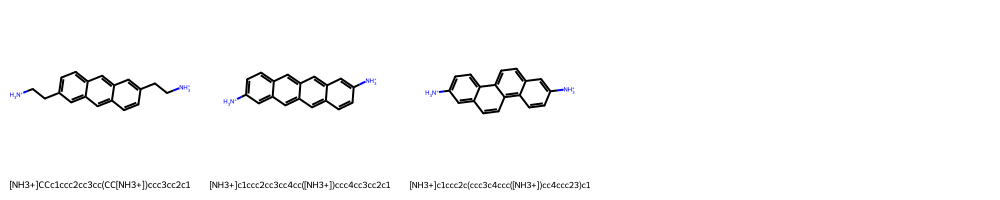

In [115]:
from utils import visualize_smiles_list

smiles_list = type_IIa_final_candidates.smiles_canonical.to_list()
visualize_smiles_list(smiles_list)

### All synthesizable candidates

In [140]:
type_Ib_candidate_dataframe = pd.read_csv(PROJECT_ROOT_DIRECTORY + '01-rawdata/19-inverse-design/type_Ib/type_Ib_synthesizable_candidates.csv')
type_Ib_candidate_dataframe['inverse_design_type'] = 'Ib'
type_IIa_1_candidate_dataframe = pd.read_csv(PROJECT_ROOT_DIRECTORY + '01-rawdata/19-inverse-design/type_IIa_1/type_IIa_synthesizable_candidates.csv')
type_IIa_1_candidate_dataframe['inverse_design_type'] = 'IIa_1'
type_IIa_2_candidate_dataframe = pd.read_csv(PROJECT_ROOT_DIRECTORY + '01-rawdata/19-inverse-design/type_IIa_2/type_IIa_synthesizable_candidates.csv')
type_IIa_2_candidate_dataframe['inverse_design_type'] = 'IIa_2'
type_IIb_candidate_dataframe = pd.read_csv(PROJECT_ROOT_DIRECTORY + '01-rawdata/19-inverse-design/type_IIb/type_IIb_synthesizable_candidates.csv')
type_IIb_candidate_dataframe['inverse_design_type'] = 'IIb'

inverse_designed_candidate_dataframe = pd.concat([type_Ib_candidate_dataframe, type_IIa_1_candidate_dataframe, type_IIa_2_candidate_dataframe, type_IIb_candidate_dataframe], ignore_index=True)
inverse_designed_candidate_dataframe

smiles_canonical  \
0      [NH3+]c1ccc2cc3cc4cc5ccc([NH3+])cc5cc4cc3cc2c1   
1      [NH3+]c1cccc2cc3cc4cc5c([NH3+])cccc5cc4cc3cc12   
2      [NH3+]c1cccc2cc3cc4cc5cccc([NH3+])c5cc4cc3cc12   
3   [NH3+]CCCc1ccc(-c2ccc(-c3ccc(-c4ccc(-c5ccc(CCC...   
4   [NH3+]CCc1ccc(-c2ccc(-c3ccc(-c4ccc(-c5ccc(CC[N...   
..                                                ...   
73                             CC([NH3+])c1c[nH+]ncn1   
74                             CC([NH3+])c1c[nH+]cnn1   
75                             CC([NH3+])c1cnc[nH+]n1   
76                             CC([NH3+])c1ccn[nH+]n1   
77                             [NH3+]Cc1c[nH+]cc(F)n1   

                           Sequence  generation  ringcount  linkage_p  \
0           [6, 6, 6, 6, 8, 11, 11]           7        5.0        0.0   
1        [6, 6, 6, 6, 8, 8, 11, 11]           8        5.0        0.0   
2     [6, 6, 6, 6, 8, 8, 8, 11, 11]           9        5.0        0.0   
3   [1, 5, 5, 5, 5, 10, 10, 10, 10]           9        5.0        1.0   
4           [1, 5, 5, 5, 5, 10, 10]           7        5.0        1.0   
..                              ...         ...        ...        ...   
73               [8, 9, 12, 12, 16]           5        1.0        0.0   
74               [8, 9, 12, 12, 16]           5        1.0        0.0   
75               [8, 9, 12, 12, 16]           5        1.0        0.0   
76               [8, 9, 12, 12, 16]           5        1.0        0.0   
77                   [8, 9, 12, 15]           4        1.0        0.0   

    six_ring_p  primaryamine  linker_length  linker_position  hetero_nitrogen  \
0          1.0           2.0            0.0         0.909091              0.0   
1          1.0           2.0            0.0         0.818182              0.0   
2          1.0           2.0            0.0         0.727273              0.0   
3          0.0           2.0            6.0         1.000000              0.0   
4          0.0           2.0            4.0         1.000000              0.0   
..         ...           ...            ...              ...              ...   
73         1.0           1.0            1.0         0.666667              2.0   
74         1.0           1.0            1.0         0.666667              2.0   
75         1.0           1.0            1.0         0.666667              2.0   
76         1.0           1.0            1.0         0.666667              2.0   
77         1.0           1.0            1.0         0.666667              1.0   

    ...      STEI  NumRot_tail  eccentricity     disNN  formability_score  \
0   ...  1.397724          1.0          12.0  0.006944           0.985303   
1   ...  1.449229          1.0          11.0  0.008264           0.985302   
2   ...  1.449477          1.0          11.0  0.010000           0.985294   
3   ...  1.219390          4.0          22.0  0.002066           0.999996   
4   ...  1.232380          3.0          20.0  0.002500           0.999996   
..  ...       ...          ...           ...       ...                ...   
73  ...  2.355324          1.0           4.0  0.062500           0.949171   
74  ...  2.355324          1.0           4.0  0.062500           0.949171   
75  ...  2.355324          1.0           4.0  0.062500           0.949171   
76  ...  2.355324          1.0           4.0  0.062500           0.949171   
77  ...  2.376736          1.0           4.0  0.062500           0.920253   

                                           iupac_name          cid  \
0                              pentacene-2,10-diamine   85868421.0   
1                               pentacene-1,8-diamine  154316963.0   
2                              pentacene-1,11-diamine   85868411.0   
3   3-[5-[5-[5-[5-[5-(3-aminopropyl)thiophen-2-yl]...   85702358.0   
4   2-[5-[5-[5-[5-[5-(2-aminoethyl)thiophen-2-yl]t...   85702350.0   
..                                                ...          ...   
73                   1-(1,2,4-triazin-5-yl)ethanamine   82593607.0   
74               

In [141]:
inverse_designed_candidate_dataframe = inverse_designed_candidate_dataframe[['smiles_canonical', 'iupac_name', 'cid', 'PubChem_existence','formability_score', 'generation','inverse_design_type'] + COLUMNS_DICT['molecular_fingerprint']]

In [142]:
inverse_designed_candidate_dataframe.to_csv(PROJECT_ROOT_DIRECTORY + '01-rawdata/19-inverse-design/inverse_designed_candidates.csv', index=False)

### DFT validation

In [143]:
inverse_designed_candidate_dataframe = pd.read_csv(PROJECT_ROOT_DIRECTORY + '01-rawdata/19-inverse-design/inverse_designed_candidates.csv')
inverse_designed_candidate_dataframe

smiles_canonical  \
0      [NH3+]c1ccc2cc3cc4cc5ccc([NH3+])cc5cc4cc3cc2c1   
1      [NH3+]c1cccc2cc3cc4cc5c([NH3+])cccc5cc4cc3cc12   
2      [NH3+]c1cccc2cc3cc4cc5cccc([NH3+])c5cc4cc3cc12   
3   [NH3+]CCCc1ccc(-c2ccc(-c3ccc(-c4ccc(-c5ccc(CCC...   
4   [NH3+]CCc1ccc(-c2ccc(-c3ccc(-c4ccc(-c5ccc(CC[N...   
..                                                ...   
73                             CC([NH3+])c1c[nH+]ncn1   
74                             CC([NH3+])c1c[nH+]cnn1   
75                             CC([NH3+])c1cnc[nH+]n1   
76                             CC([NH3+])c1ccn[nH+]n1   
77                             [NH3+]Cc1c[nH+]cc(F)n1   

                                           iupac_name          cid  \
0                              pentacene-2,10-diamine   85868421.0   
1                               pentacene-1,8-diamine  154316963.0   
2                              pentacene-1,11-diamine   85868411.0   
3   3-[5-[5-[5-[5-[5-(3-aminopropyl)thiophen-2-yl]...   85702358.0   
4   2-[5-[5-[5-[5-[5-(2-aminoethyl)thiophen-2-yl]t...   85702350.0   
..                                                ...          ...   
73                   1-(1,2,4-triazin-5-yl)ethanamine   82593607.0   
74                   1-(1,2,4-triazin-6-yl)ethanamine   83826171.0   
75                   1-(1,2,4-triazin-6-yl)ethanamine   83826171.0   
76                         1-(triazin-4-yl)ethanamine   69776878.0   
77                  (6-fluoropyrazin-2-yl)methanamine  142741436.0   

    PubChem_existence  formability_score  generation inverse_design_type  \
0                True           0.985303           7                  Ib   
1                True           0.985302           8                  Ib   
2                True           0.985294           9                  Ib   
3                True           0.999996           9               IIa_1   
4                True           0.999996           7               IIa_1   
..                ...                ...         ...                 ...   
73               True           0.949171           5                 IIb   
74               True           0.949171           5                 IIb   
75               True           0.949171           5                 IIb   
76               True           0.949171           5                 IIb   
77               True           0.920253           4                 IIb   

    ringcount  linkage_p  six_ring_p  primaryamine  linker_length  \
0         5.0        0.0         1.0           2.0            0.0   
1         5.0        0.0         1.0           2.0            0.0   
2         5.0        0.0         1.0           2.0            0.0   
3         5.0        1.0         0.0           2.0            6.0   
4         5.0        1.0         0.0           2.0            4.0   
..        ...        ...         ...           ...            ...   
73        1.0        0.0         1.0           1.0            1.0   
74        1.0        0.0         1.0           1.0            1.0   
75        1.0        0.0         1.0           1.0            1.0   
76        1.0        0.0         1.0           1.0            1.0   
77        1.0        0.0         1.0           1.0            1.0   

    linker_position  hetero_nitrogen  fluorination  furan  pyrrole  \
0          0.909091              0.0           0.0    0.0      0.0   
1          0.818182              0.0           0.0    0.0      0.0   
2          0.727273              0.0           0.0    0.0      0.0   
3          1.000000              0.0           0.0    0.0      0.0   
4          1.000000              0.0           0.0    0.0      0.0   
..              ...              ...           ...    ...      ...   
73         0.666667              2.0           0.0    0.0      0.0   
74         0.666667              2.0           0.0    0.0      0.0   
75         0.666667              2.0           0.0    0.0      0.0   
76         0.666667              2.0           0.0    0.0      0.0   

In [144]:
hse_frontier_dataframe = pd.read_csv(
    PROJECT_ROOT_DIRECTORY + '02-metadata/06-csv-files/08-hse-frontier.csv', index_col='identifier'
)
organic_genome_dataframe = pd.read_csv(
    PROJECT_ROOT_DIRECTORY + '02-metadata/06-csv-files/01-organic-genome.csv', index_col='identifier'
)

combined_dataframe = pd.merge(organic_genome_dataframe, hse_frontier_dataframe, left_index=True, right_index=True, how='outer')
combined_dataframe


smiles_canonical  generation  \
identifier                                                      
1                    [NH3+]Cc1cc2sc(C[NH3+])cc2s1         2.0   
2                     [NH3+]Cc1cc2sc([NH3+])cc2s1         3.0   
3                      [NH3+]c1cc2sc([NH3+])cc2s1         4.0   
4                         [NH3+]Cc1ccc(C[NH3+])s1         1.0   
5                         [NH3+]Cc1ccc(C[NH3+])o1         2.0   
...                                           ...         ...   
40605       [NH3+]Cc1ccc2nc(-c3cs[nH+]n3)[nH]c2c1         6.0   
40606       [NH3+]Cc1ccc2nc(-c3cn[nH+]s3)[nH]c2c1         6.0   
40607                 Cc1c[nH+]nc2oc(C[NH3+])nc12         6.0   
40608              Cc1c[nH+]nc2sc(C(C)[NH3+])nc12         6.0   
40609                     Cc1nc[nH+]nc1C(C)[NH3+]         6.0   

            inorganic_cbm_gamma  inorganic_cbm_z  inorganic_vbm_gamma  \
identifier                                                              
1                      2.618151         2.618151            -0.066349   
2                           NaN              NaN                  NaN   
3                           NaN              NaN                  NaN   
4                      2.583026         2.583026             0.006826   
5                      2.419301         2.419301             0.184801   
...                         ...              ...                  ...   
40605                       NaN              NaN                  NaN   
40606                       NaN              NaN                  NaN   
40607                       NaN              NaN                  NaN   
40608                       NaN              NaN                  NaN   
40609                       NaN              NaN                  NaN   

            inorganic_vbm_z  organic_LUMO  organic_HOMO alignment_type  
identifier                                                              
1                 -0.066349      3.901251     -0.772949             Ia  
2                       NaN           NaN           NaN            NaN  
3                       NaN           NaN           NaN            NaN  
4                  0.006826      4.142126     -1.545974             Ia  
5                  0.184801      4.525701     -1.222399             Ia  
...                     ...           ...           ...            ...  
40605                   NaN           NaN           NaN            NaN  
40606                   NaN           NaN           NaN            NaN  
40607                   NaN           NaN           NaN            NaN  
40608                   NaN           NaN           NaN            NaN  
40609                   NaN           NaN           NaN            NaN  

[40609 rows x 9 columns]

In [149]:
new_dataframe = pd.merge(combined_dataframe.drop(columns='generation').reset_index(), inverse_designed_candidate_dataframe, on='smiles_canonical', how='right')


In [150]:
new_dataframe

identifier                                   smiles_canonical  \
0        36236     [NH3+]c1ccc2cc3cc4cc5ccc([NH3+])cc5cc4cc3cc2c1   
1          186     [NH3+]c1cccc2cc3cc4cc5c([NH3+])cccc5cc4cc3cc12   
2          197     [NH3+]c1cccc2cc3cc4cc5cccc([NH3+])c5cc4cc3cc12   
3          182  [NH3+]CCCc1ccc(-c2ccc(-c3ccc(-c4ccc(-c5ccc(CCC...   
4          179  [NH3+]CCc1ccc(-c2ccc(-c3ccc(-c4ccc(-c5ccc(CC[N...   
..         ...                                                ...   
73       40549                             CC([NH3+])c1c[nH+]ncn1   
74       40550                             CC([NH3+])c1c[nH+]cnn1   
75       40551                             CC([NH3+])c1cnc[nH+]n1   
76       40552                             CC([NH3+])c1ccn[nH+]n1   
77       34230                             [NH3+]Cc1c[nH+]cc(F)n1   

    inorganic_cbm_gamma  inorganic_cbm_z  inorganic_vbm_gamma  \
0              2.543726         2.543726             0.036626   
1              2.644226         2.644226             0.015026   
2                   NaN              NaN                  NaN   
3              2.656426         2.656426             0.060626   
4              2.364351         2.364351             0.198751   
..                  ...              ...                  ...   
73             2.644501         2.599601            -0.029299   
74             2.696451         2.657551            -0.128749   
75             2.622351         2.586951            -0.173449   
76             2.539926         2.502726            -0.208674   
77                  NaN              NaN                  NaN   

    inorganic_vbm_z  organic_LUMO  organic_HOMO alignment_type  \
0          0.036626      2.327226      0.393326             Ib   
1          0.015026      2.481126      0.601826             Ib   
2               NaN           NaN           NaN            NaN   
3          0.060626      3.531026      0.967426            IIa   
4          0.198751      3.476251      0.886451            IIa   
..              ...           ...           ...            ...   
73         0.138101      1.742201     -4.080499            IIb   
74         0.035751      1.768451     -3.316249            IIb   
75         0.100651      1.818351     -3.827049            IIb   
76         0.155426      1.514726     -4.564974            IIb   
77              NaN           NaN           NaN            NaN   

                                           iupac_name  ...  six_ring_p  \
0                              pentacene-2,10-diamine  ...         1.0   
1                               pentacene-1,8-diamine  ...         1.0   
2                              pentacene-1,11-diamine  ...         1.0   
3   3-[5-[5-[5-[5-[5-(3-aminopropyl)thiophen-2-yl]...  ...         0.0   
4   2-[5-[5-[5-[5-[5-(2-aminoethyl)thiophen-2-yl]t...  ...         0.0   
..                                                ...  ...         ...   
73                   1-(1,2,4-triazin-5-yl)ethanamine  ...         1.0   
74                   1-(1,2,4-triazin-6-yl)ethanamine  ...         1.0   
75                   1-(1,2,4-triazin-6-yl)ethanamine  ...         1.0   
76                         1-(triazin-4-yl)ethanamine  ...         1.0   
77                  (6-fluoropyrazin-2-yl)methanamine  ...         1.0   

    primaryamine  linker_length  linker_position hetero_nitrogen  \
0            2.0            0.0         0.909091             0.0   
1            2.0            0.0         0.818182             0.0   
2            2.0            0.0         0.727273             0.0   
3            2.0            6.0         1.000000             0.0   
4            2.0            4.0         1.000000             0.0   
..           ...            ...              ...             ...   
73           1.0            1.0         0.666667             2.0   
74           1.0            1.0         0.666667             2.0   
75           1.0            1.0         0.666667             2.0   
76           1.0            1.0 

In [151]:
new_dataframe.query('alignment_type != "Ia"' ).value_counts('alignment_type')

alignment_type
IIb    48
IIa    12
Ib      2
Name: count, dtype: int64

In [154]:
type_IIa_dataframe = new_dataframe.query('alignment_type == "IIa"').reset_index(drop=True)
type_IIa_dataframe.to_csv(PROJECT_ROOT_DIRECTORY + '01-rawdata/19-inverse-design/validated-candidates/type_IIa_validated_final_candidates.csv', index=False)

In [155]:
type_Ib_dataframe = new_dataframe.query('alignment_type == "Ib"').reset_index(drop=True)
type_Ib_dataframe.to_csv(PROJECT_ROOT_DIRECTORY + '01-rawdata/19-inverse-design/validated-candidates/type_Ib_validated_final_candidates.csv', index=False)

In [156]:
type_IIb_dataframe = new_dataframe.query('alignment_type == "IIb"').reset_index(drop=True)
type_IIb_dataframe.to_csv(PROJECT_ROOT_DIRECTORY + '01-rawdata/19-inverse-design/validated-candidates/type_IIb_validated_final_candidates.csv', index=False)

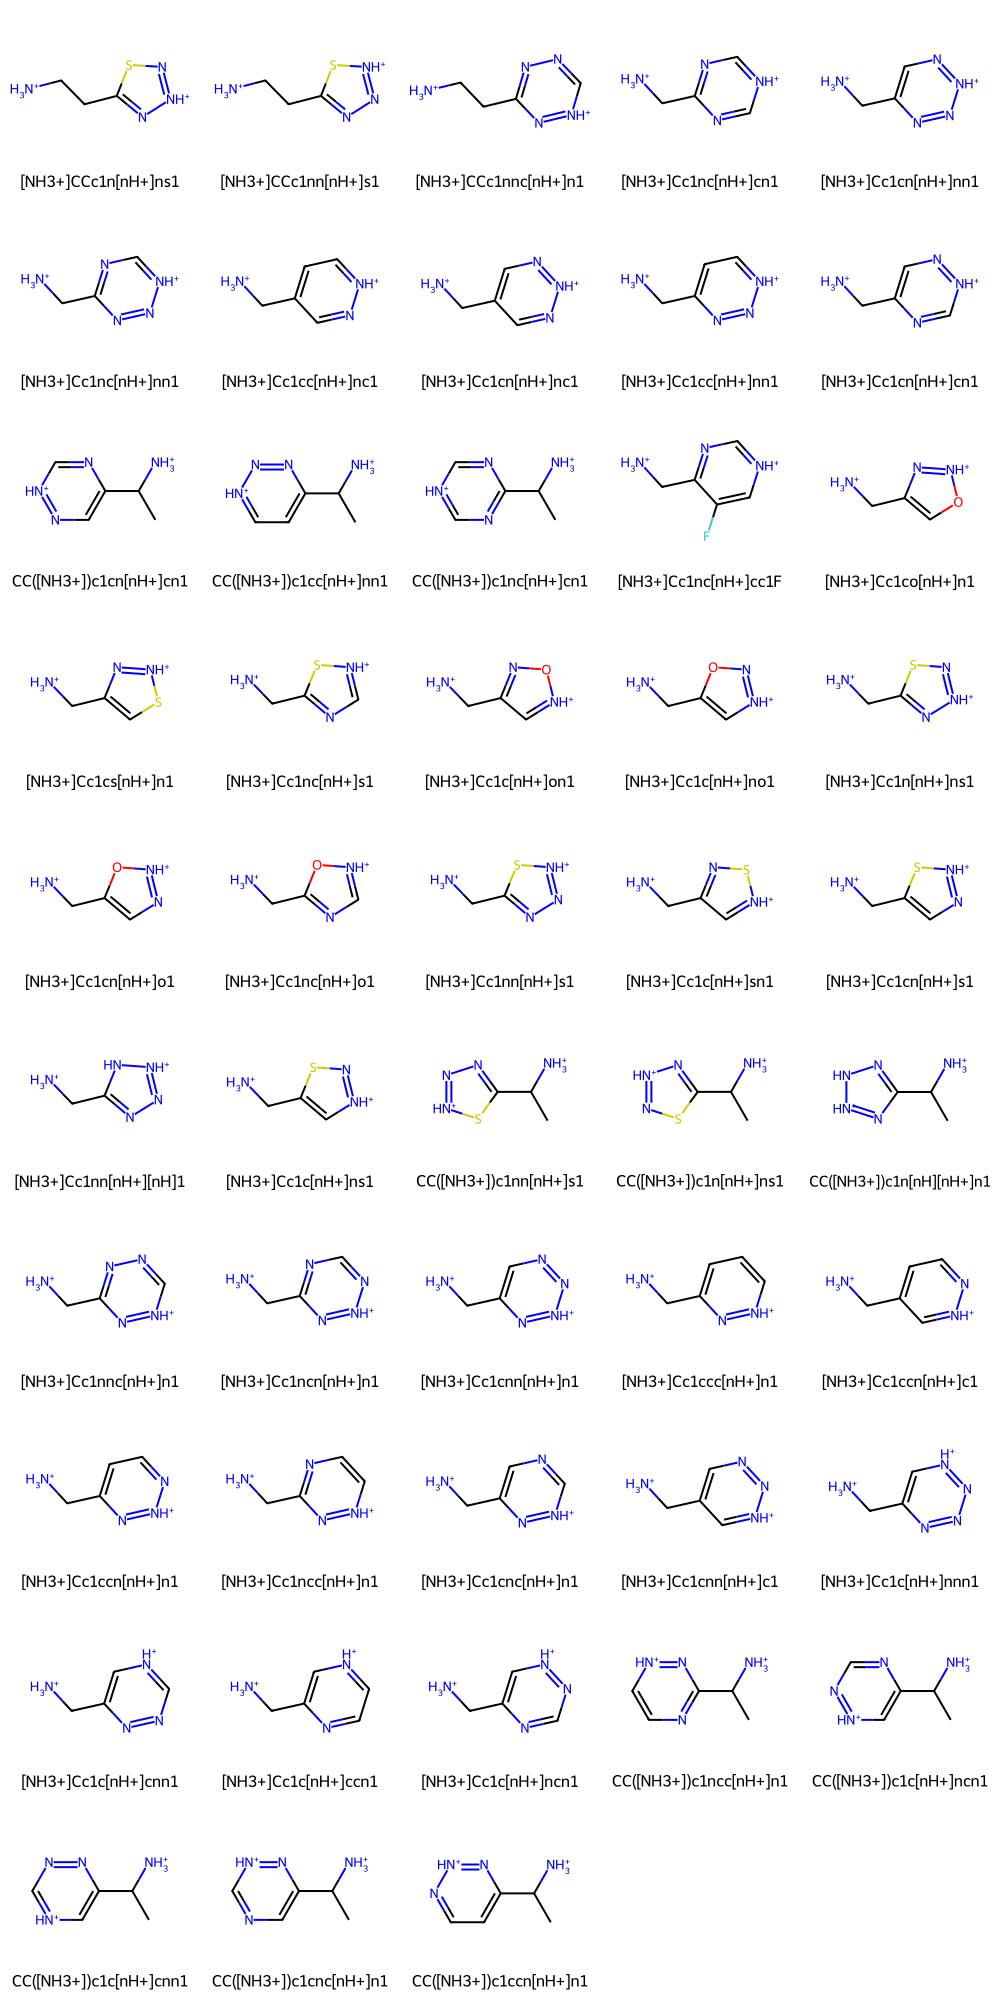

In [158]:
from utils import visualize_smiles_list
smiles_list = type_IIb_dataframe.smiles_canonical.to_list()
visualize_smiles_list(smiles_list)

### Statistic of organic spacers

In [18]:
import pandas as pd
type_Ib_candidate_dataframe = pd.read_csv(PROJECT_ROOT_DIRECTORY + '01-rawdata/19-inverse-design/validated-candidates/type_Ib_validated_final_candidates.csv')
type_IIa_candidate_dataframe = pd.read_csv(PROJECT_ROOT_DIRECTORY + '01-rawdata/19-inverse-design/validated-candidates/type_IIa_validated_final_candidates.csv')
type_IIb_candidate_dataframe = pd.read_csv(PROJECT_ROOT_DIRECTORY + '01-rawdata/19-inverse-design/validated-candidates/type_IIb_validated_final_candidates.csv')
inverse_designed_candidate_dataframe = pd.read_csv(PROJECT_ROOT_DIRECTORY + '01-rawdata/19-inverse-design/inverse_designed_candidates.csv')

In [11]:
type_Ib_candidate_dataframe[['identifier', 'smiles_canonical', 'iupac_name', 'cid','formability_score', 'generation']]

identifier                                smiles_canonical  \
0       36236  [NH3+]c1ccc2cc3cc4cc5ccc([NH3+])cc5cc4cc3cc2c1   
1         186  [NH3+]c1cccc2cc3cc4cc5c([NH3+])cccc5cc4cc3cc12   

               iupac_name          cid  formability_score  generation  
0  pentacene-2,10-diamine   85868421.0           0.985303           7  
1   pentacene-1,8-diamine  154316963.0           0.985302           8

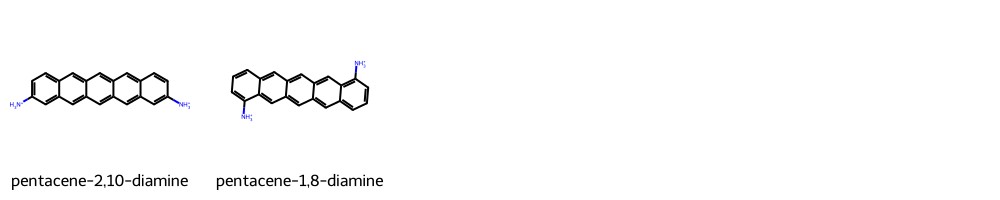

In [8]:
from utils import visualize_smiles_list
smiles_list = type_Ib_candidate_dataframe.smiles_canonical.to_list()
visualize_smiles_list(smiles_list, legends=type_Ib_candidate_dataframe.iupac_name.to_list())

In [15]:
type_IIa_candidate_dataframe[['identifier', 'smiles_canonical', 'iupac_name', 'cid','formability_score', 'generation']]

identifier                                   smiles_canonical  \
0          182  [NH3+]CCCc1ccc(-c2ccc(-c3ccc(-c4ccc(-c5ccc(CCC...   
1          179  [NH3+]CCc1ccc(-c2ccc(-c3ccc(-c4ccc(-c5ccc(CC[N...   
2          181  [NH3+]CCCc1ccc(-c2ccc(-c3ccc(-c4ccc(CCC[NH3+])...   
3          206  [NH3+]CCc1ccc(-c2ccc(-c3ccc(-c4ccc(CC[NH3+])s4...   
4          180    [NH3+]CCCc1ccc(-c2ccc(-c3ccc(CCC[NH3+])s3)s2)s1   
5          239  [NH3+]Cc1ccc(-c2ccc(-c3ccc(-c4ccc(-c5ccc(C[NH3...   
6          189      [NH3+]CCc1ccc(-c2ccc(-c3ccc(CC[NH3+])s3)s2)s1   
7          102  [NH3+]Cc1ccc(-c2ccc(-c3ccc(-c4ccc(C[NH3+])s4)s...   
8        35575              [NH3+]CCCc1ccc(-c2ccc(CCC[NH3+])s2)s1   
9          205                [NH3+]CCc1ccc(-c2ccc(CC[NH3+])s2)s1   
10       36228  [NH3+]c1ccc(-c2ccc(-c3ccc(-c4ccc([NH3+])s4)s3)...   
11       27437             [NH3+]CCc1ccc2cc3cc(CC[NH3+])ccc3cc2c1   

                                           iupac_name          cid  \
0   3-[5-[5-[5-[5-[5-(3-aminopropyl)thiophen-2-yl]...   85702358.0   
1   2-[5-[5-[5-[5-[5-(2-aminoethyl)thiophen-2-yl]t...   85702350.0   
2   3-[5-[5-[5-[5-(3-aminopropyl)thiophen-2-yl]thi...   85702356.0   
3   2-[5-[5-[5-[5-(2-aminoethyl)thiophen-2-yl]thio...   10835744.0   
4   3-[5-[5-[5-(3-aminopropyl)thiophen-2-yl]thioph...   85702353.0   
5   [5-[5-[5-[5-[5-(aminomethyl)thiophen-2-yl]thio...   10719177.0   
6   2-[5-[5-[5-(2-aminoethyl)thiophen-2-yl]thiophe...   85702348.0   
7   [5-[5-[5-[5-(aminomethyl)thiophen-2-yl]thiophe...     392006.0   
8   3-[5-[5-(3-aminopropyl)thiophen-2-yl]thiophen-...   85702352.0   
9   2-[5-[5-(2-aminoethyl)thiophen-2-yl]thiophen-2...  170868983.0   
10  5-[5-[5-(5-aminothiophen-2-yl)thiophen-2-yl]th...  142729566.0   
11       2-[6-(2-aminoethyl)anthracen-2-yl]ethanamine  138986756.0   

    formability_score  generation  
0            0.999996           9  
1            0.999996           7  
2            0.999996           8  
3            0.999995           6  
4            0.999995           7  
5            0.999995           5  
6            0.999994           5  
7            0.999994           4  
8            0.999994           6  
9            0.999992           4  
10           0.985304           6  
11           0.999994           4

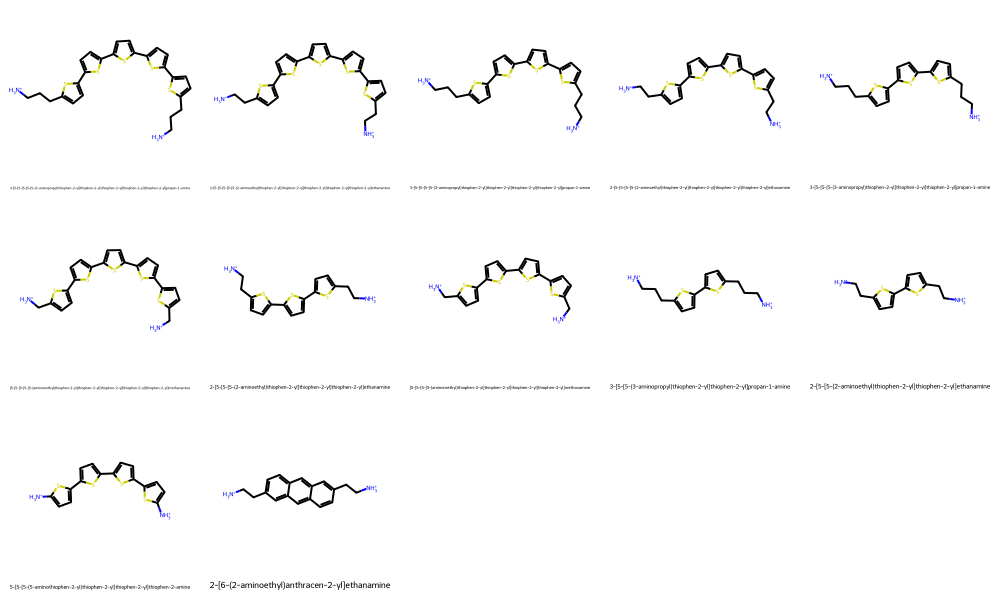

In [13]:
smiles_list = type_IIa_candidate_dataframe.smiles_canonical.to_list()
visualize_smiles_list(smiles_list, legends=type_IIa_candidate_dataframe.iupac_name.to_list())

In [16]:
type_IIb_candidate_dataframe[['identifier', 'smiles_canonical', 'iupac_name', 'cid','formability_score', 'generation']]

identifier          smiles_canonical                           iupac_name  \
0        40544       [NH3+]CCc1n[nH+]ns1       2-(thiatriazol-5-yl)ethanamine   
1        40541       [NH3+]CCc1nn[nH+]s1       2-(thiatriazol-5-yl)ethanamine   
2        40558      [NH3+]CCc1nnc[nH+]n1  2-(1,2,4,5-tetrazin-3-yl)ethanamine   
3          111       [NH3+]Cc1nc[nH+]cn1        1,3,5-triazin-2-ylmethanamine   
4        34293       [NH3+]Cc1cn[nH+]nn1             tetrazin-5-ylmethanamine   
5        34289       [NH3+]Cc1nc[nH+]nn1     1,2,3,5-tetrazin-4-ylmethanamine   
6          376       [NH3+]Cc1cc[nH+]nc1            pyridazin-4-ylmethanamine   
7         1680       [NH3+]Cc1cn[nH+]nc1              triazin-5-ylmethanamine   
8         1675       [NH3+]Cc1cc[nH+]nn1              triazin-4-ylmethanamine   
9         1674       [NH3+]Cc1cn[nH+]cn1        1,2,4-triazin-5-ylmethanamine   
10       34296    CC([NH3+])c1cn[nH+]cn1     1-(1,2,4-triazin-5-yl)ethanamine   
11       34301    CC([NH3+])c1cc[nH+]nn1           1-(triazin-4-yl)ethanamine   
12       34291    CC([NH3+])c1nc[nH+]cn1     1-(1,3,5-triazin-2-yl)ethanamine   
13        1676      [NH3+]Cc1nc[nH+]cc1F  (5-fluoropyrimidin-4-yl)methanamine   
14        8401        [NH3+]Cc1co[nH+]n1            oxadiazol-4-ylmethanamine   
15         640        [NH3+]Cc1cs[nH+]n1           thiadiazol-4-ylmethanamine   
16         440        [NH3+]Cc1nc[nH+]s1     1,2,4-thiadiazol-5-ylmethanamine   
17        8412        [NH3+]Cc1c[nH+]on1      1,2,5-oxadiazol-3-ylmethanamine   
18        7979        [NH3+]Cc1c[nH+]no1            oxadiazol-5-ylmethanamine   
19        7971        [NH3+]Cc1n[nH+]ns1          thiatriazol-5-ylmethanamine   
20        3884        [NH3+]Cc1cn[nH+]o1            oxadiazol-5-ylmethanamine   
21        3883        [NH3+]Cc1nc[nH+]o1      1,2,4-oxadiazol-5-ylmethanamine   
22        3787        [NH3+]Cc1nn[nH+]s1          thiatriazol-5-ylmethanamine   
23         641        [NH3+]Cc1c[nH+]sn1     1,2,5-thiadiazol-3-ylmethanamine   
24         441        [NH3+]Cc1cn[nH+]s1           thiadiazol-5-ylmethanamine   
25       40542     [NH3+]Cc1nn[nH+][nH]1          2H-tetrazol-5-ylmethanamine   
26         635        [NH3+]Cc1c[nH+]ns1           thiadiazol-5-ylmethanamine   
27       40543     CC([NH3+])c1nn[nH+]s1       1-(thiatriazol-5-yl)ethanamine   
28       40546     CC([NH3+])c1n[nH+]ns1       1-(thiatriazol-5-yl)ethanamine   
29       40557  CC([NH3+])c1n[nH][nH+]n1       1-(2H-tetrazol-5-yl)ethanamine   
30       36192       [NH3+]Cc1nnc[nH+]n1     1,2,4,5-tetrazin-3-ylmethanamine   
31       36193       [NH3+]Cc1ncn[nH+]n1     1,2,3,5-tetrazin-4-ylmethanamine   
32       36195       [NH3+]Cc1cnn[nH+]n1             tetrazin-5-ylmethanamine   
33        1673       [NH3+]Cc1ccc[nH+]n1            pyridazin-3-ylmethanamine   
34        1672       [NH3+]Cc1ccn[nH+]c1            pyridazin-4-ylmethanamine   
35       34244       [NH3+]Cc1ccn[nH+]n1              triazin-4-ylmethanamine   
36       34225       [NH3+]Cc1ncc[nH+]n1        1,2,4-triazin-3-ylmethanamine   
37       34236       [NH3+]Cc1cnc[nH+]n1        1,2,4-triazin-6-ylmethanamine   
38       34235       [NH3+]Cc1cnn[nH+]c1              triazin-5-ylmethanamine   
39       36194       [NH3+]Cc1c[nH+]nnn1             tetrazin-5-ylmethanamine   
40       34227       [NH3+]Cc1c[nH+]cnn1        1,2,4-triazin-6-ylmethanamine   
41         110       [NH3+]Cc1c[nH+]ccn1              pyrazin-2-ylmethanamine   
42       34226       [NH3+]Cc1c[nH+]ncn1        1,2,4-triazin-5-ylmethanamine   
43       40548    CC([NH3+])c1ncc[nH+]n1     1-(1,2,4-triazin-3-yl)ethanamine   
44       40549    CC([NH3+])c1c[nH+]ncn1     1-(1,2,4-triazin-5-yl)ethanamine   
45       40550    CC([NH3+])c1c[nH+]cnn1     1-(1,2,4-triazin-6-yl)ethanamine   
46       40551    CC([NH3+])c1cnc[nH+]n1     1-(1,2,4-triazin-6-yl)ethanamine   
47       40552    CC([NH3+])c1ccn[nH+]n1           1-(triazin-4-yl)ethanamine   

            cid  formability_score

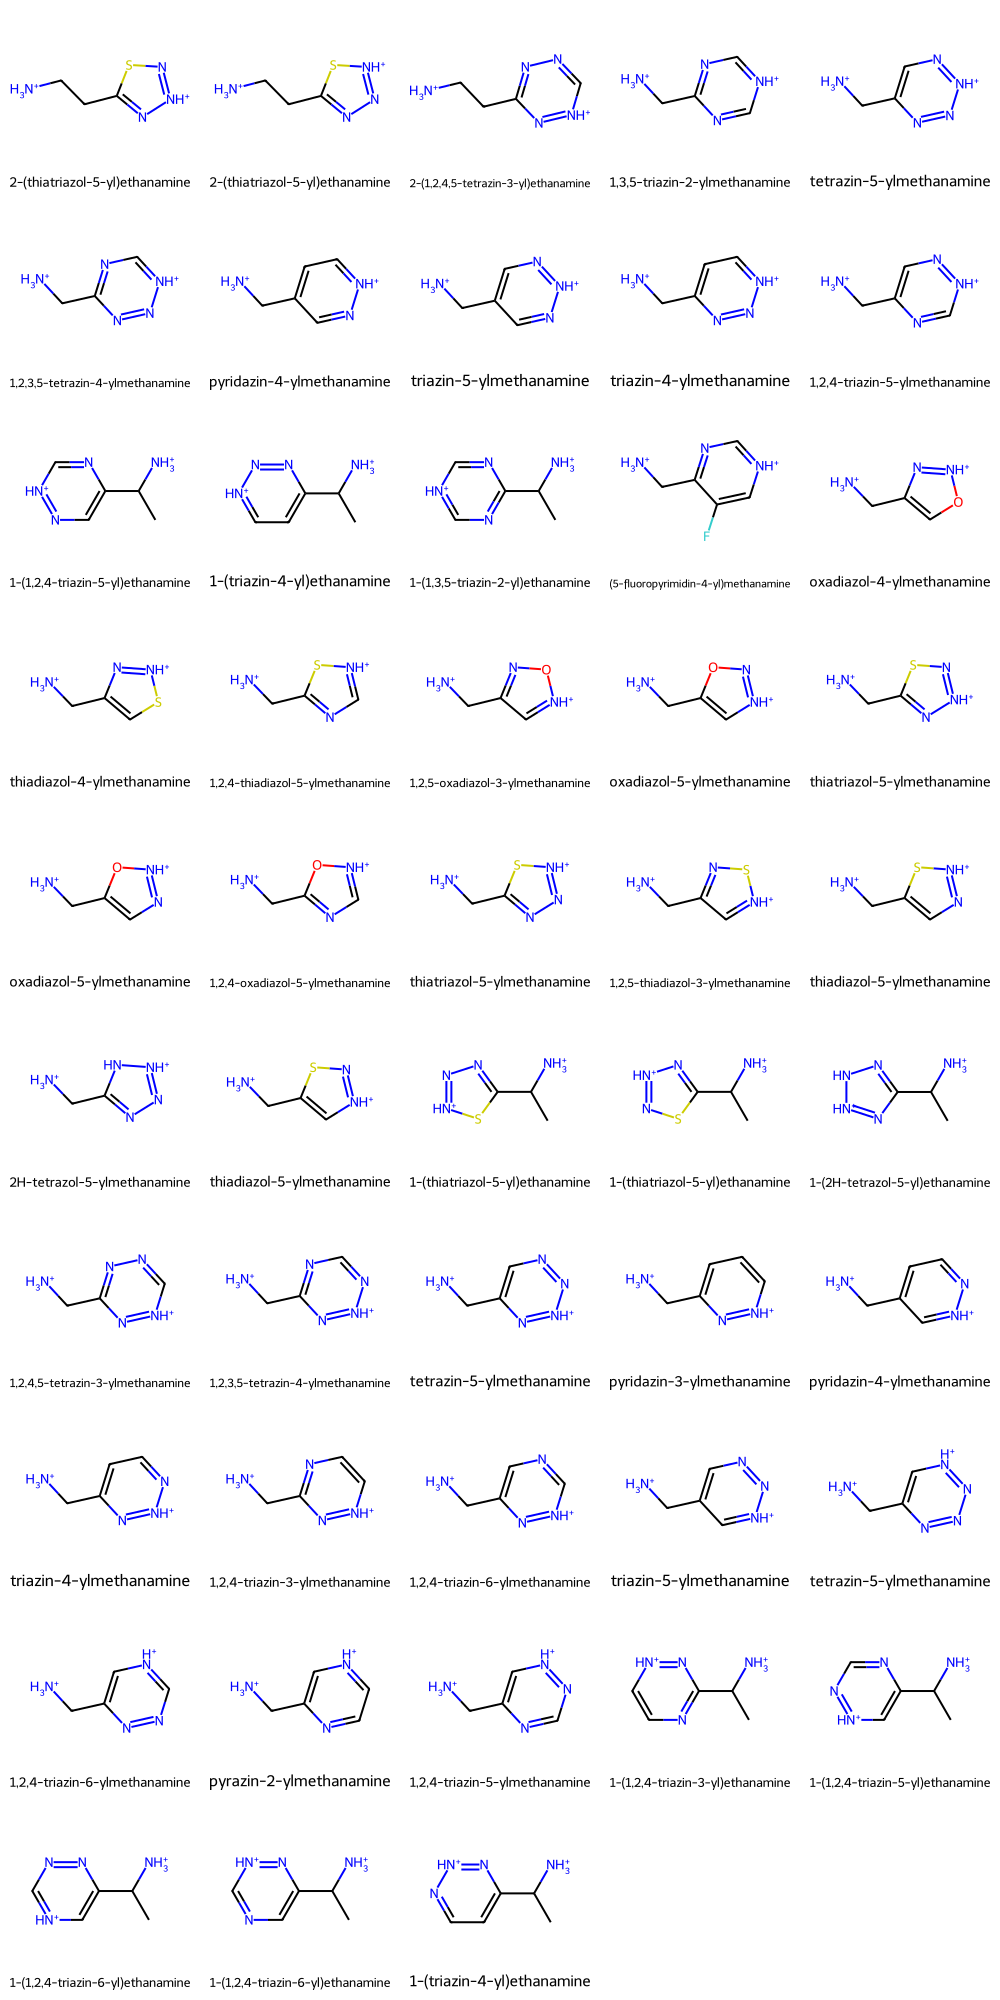

In [17]:
smiles_list = type_IIb_candidate_dataframe.smiles_canonical.to_list()
visualize_smiles_list(smiles_list, legends=type_IIb_candidate_dataframe.iupac_name.to_list())

In [21]:
inverse_designed_candidate_dataframe[['smiles_canonical', 'iupac_name', 'cid','formability_score', 'generation']]

smiles_canonical  \
0      [NH3+]c1ccc2cc3cc4cc5ccc([NH3+])cc5cc4cc3cc2c1   
1      [NH3+]c1cccc2cc3cc4cc5c([NH3+])cccc5cc4cc3cc12   
2      [NH3+]c1cccc2cc3cc4cc5cccc([NH3+])c5cc4cc3cc12   
3   [NH3+]CCCc1ccc(-c2ccc(-c3ccc(-c4ccc(-c5ccc(CCC...   
4   [NH3+]CCc1ccc(-c2ccc(-c3ccc(-c4ccc(-c5ccc(CC[N...   
..                                                ...   
73                             CC([NH3+])c1c[nH+]ncn1   
74                             CC([NH3+])c1c[nH+]cnn1   
75                             CC([NH3+])c1cnc[nH+]n1   
76                             CC([NH3+])c1ccn[nH+]n1   
77                             [NH3+]Cc1c[nH+]cc(F)n1   

                                           iupac_name          cid  \
0                              pentacene-2,10-diamine   85868421.0   
1                               pentacene-1,8-diamine  154316963.0   
2                              pentacene-1,11-diamine   85868411.0   
3   3-[5-[5-[5-[5-[5-(3-aminopropyl)thiophen-2-yl]...   85702358.0   
4   2-[5-[5-[5-[5-[5-(2-aminoethyl)thiophen-2-yl]t...   85702350.0   
..                                                ...          ...   
73                   1-(1,2,4-triazin-5-yl)ethanamine   82593607.0   
74                   1-(1,2,4-triazin-6-yl)ethanamine   83826171.0   
75                   1-(1,2,4-triazin-6-yl)ethanamine   83826171.0   
76                         1-(triazin-4-yl)ethanamine   69776878.0   
77                  (6-fluoropyrazin-2-yl)methanamine  142741436.0   

    formability_score  generation  
0            0.985303           7  
1            0.985302           8  
2            0.985294           9  
3            0.999996           9  
4            0.999996           7  
..                ...         ...  
73           0.949171           5  
74           0.949171           5  
75           0.949171           5  
76           0.949171           5  
77           0.920253           4  

[78 rows x 5 columns]

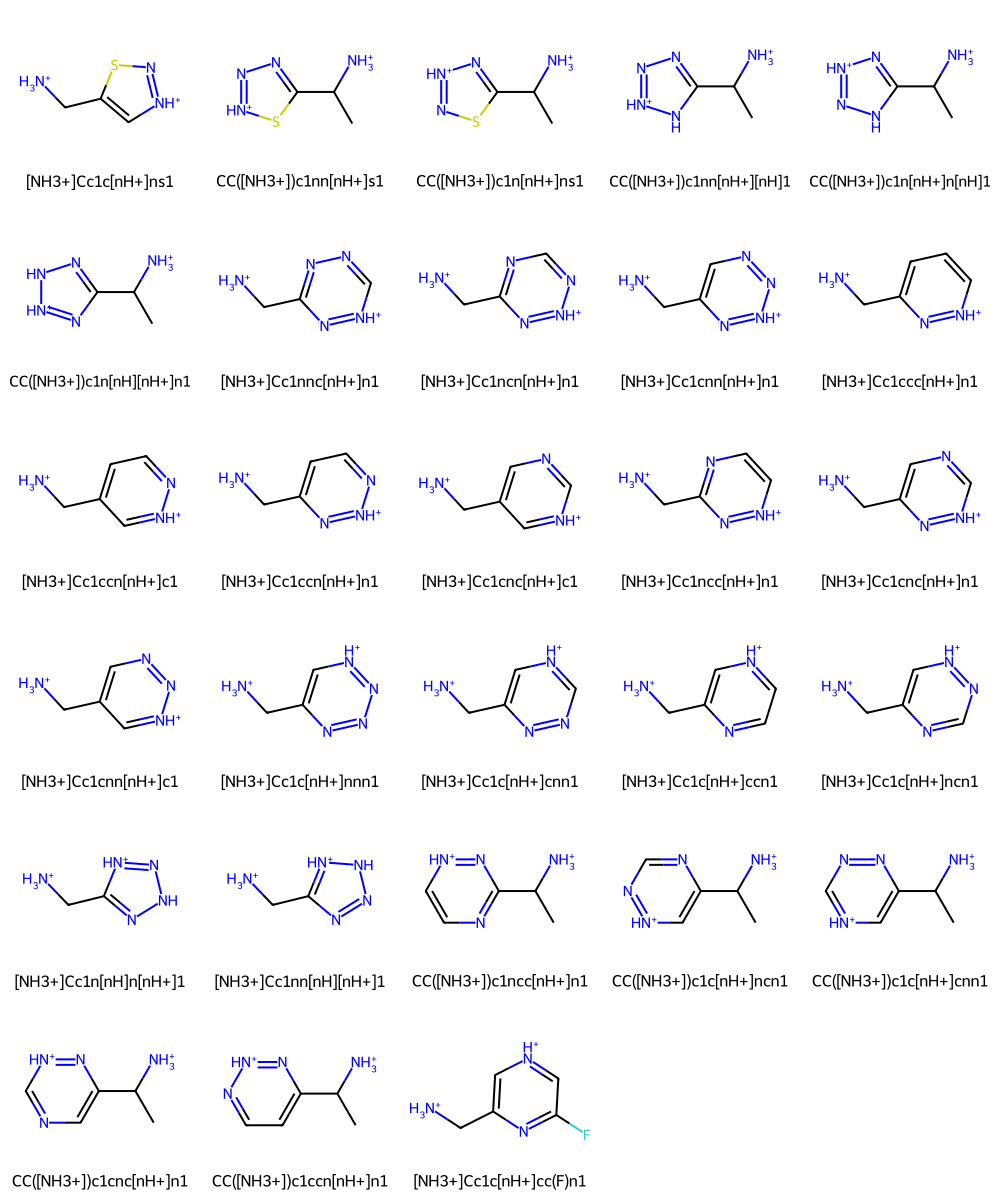

In [26]:
smiles_list = inverse_designed_candidate_dataframe.smiles_canonical.to_list()
visualize_smiles_list(smiles_list[50:])

In [ ]:
type_IIa_candidate_dataframe = pd.read_csv(PROJECT_ROOT_DIRECTORY + '01-rawdata/19-final-candidates/type_IIa/type_IIa_selected_candidates.csv')


In [61]:
type_IIb_candidate_dataframe = pd.read_csv(PROJECT_ROOT_DIRECTORY + '01-rawdata/19-final-candidates/type_IIb/type_IIb_candidates.csv')
type_IIb_candidate_dataframe['pubchem_existence'] = False
type_IIb_selected_candidate_dataframe = pd.read_csv(PROJECT_ROOT_DIRECTORY + '01-rawdata/19-final-candidates/type_IIb/type_IIb_selected_candidates.csv')
for smiles_canonical in type_IIb_selected_candidate_dataframe['smiles_canonical']:
    type_IIb_candidate_dataframe.loc[type_IIb_candidate_dataframe['smiles_canonical'] == smiles_canonical, 'pubchem_existence'] = type_IIb_selected_candidate_dataframe.loc[type_IIb_selected_candidate_dataframe['smiles_canonical'] == smiles_canonical, 'pubchem_existence'].values[0]


In [62]:
type_IIb_candidate_dataframe

smiles_canonical                               Sequence  \
0               [NH3+]c1cc[nH+]cc1                                [9, 11]   
1              [NH3+]Cc1cc[nH+]cn1                                [9, 12]   
2              [NH3+]Cc1cc[nH+]nc1                                [9, 12]   
3                [NH3+]c1cc[nH+]s1                             [1, 9, 11]   
4               [NH3+]Cc1nc[nH+]s1                             [1, 9, 12]   
..                             ...                                    ...   
818     CC([NH3+])C(C)c1nnnn[nH+]1  [8, 8, 9, 10, 12, 12, 12, 12, 16, 16]   
819  CC([NH3+])C(C)c1nnnc(F)[nH+]1  [8, 8, 9, 10, 12, 12, 12, 15, 16, 16]   
820  CC([NH3+])C(C)c1nnc(F)n[nH+]1  [8, 8, 9, 10, 12, 12, 12, 15, 16, 16]   
821  CC([NH3+])C(C)c1nc(F)nn[nH+]1  [8, 8, 9, 10, 12, 12, 12, 15, 16, 16]   
822    CC([NH3+])C(C)c1[nH+]nnnc1F  [8, 8, 9, 10, 12, 12, 12, 15, 16, 16]   

     generation  ringcount  linkage_p  six_ring_p  primaryamine  \
0             2        1.0        0.0         1.0           1.0   
1             2        1.0        0.0         1.0           1.0   
2             2        1.0        0.0         1.0           1.0   
3             3        1.0        0.0         0.0           1.0   
4             3        1.0        0.0         0.0           1.0   
..          ...        ...        ...         ...           ...   
818          10        1.0        0.0         1.0           1.0   
819          10        1.0        0.0         1.0           1.0   
820          10        1.0        0.0         1.0           1.0   
821          10        1.0        0.0         1.0           1.0   
822          10        1.0        0.0         1.0           1.0   

     linker_length  linker_position  hetero_nitrogen  ...  LRS  HDC  \
0              0.0         1.000000              0.0  ...  6.0  1.0   
1              1.0         1.000000              1.0  ...  6.0  1.0   
2              1.0         1.000000              1.0  ...  6.0  1.0   
3              0.0         1.000000              0.0  ...  5.0  1.0   
4              1.0         1.000000              1.0  ...  5.0  1.0   
..             ...              ...              ...  ...  ...  ...   
818            2.0         0.333333              4.0  ...  6.0  1.0   
819            2.0         0.333333              3.0  ...  6.0  1.0   
820            2.0         0.333333              3.0  ...  6.0  1.0   
821            2.0         0.333333              3.0  ...  6.0  1.0   
822            2.0         0.333333              3.0  ...  6.0  1.0   

          MolWt  NumN  STEI_decision  NumRot_tail_decision  \
0     94.067651   2.0           True                 False   
1    109.078550   2.0           True                  True   
2    109.078550   2.0           True                  True   
3    100.024072   2.0           True                 False   
4    115.034971   2.0           True                  True   
..          ...   ...            ...                   ...   
818  154.111247   2.0          False                  True   
819  171.106576   2.0          False                  True   
820  171.106576   2.0          False                  True   
821  171.106576   2.0          False                  True   
822  171.106576   2.0          False                  True   

     eccentricity_decision disNN_decision  formability_decision  \
0                     True           True                 False   
1                     True           True                  True   
2                     True           True                  True   
3                    False          False                 False   
4                     True           True                  True   
..                     ...            ...                   ...   
818                   True           True                 False   
819                   True           True                 False   
820                   True           True                 False   
821                 

/var/folders/tn/23sfm0zs5f725m1tjsjgv1tc0000gn/T/ipykernel_13577/4268236797.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['no. rings', '% ring linkage', '% 6-membered rings','no. primary ammonium', 'linker length', 'ammonium position', 'no. N (pyridine)', 'no. F', 'no. O (furan)', 'no. N (pyrrole)', 'no. side chain (linker)', 'no. side chain (backbone)'])


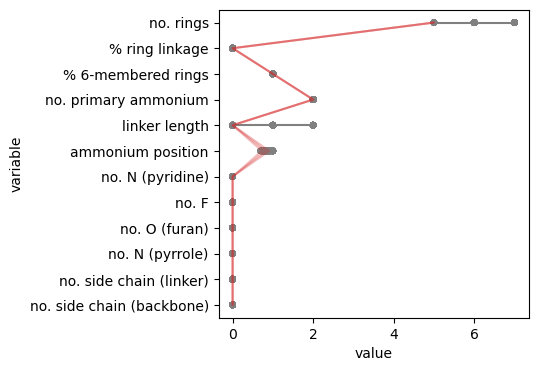

In [ ]:
import seaborn.objects as so
import matplotlib.pyplot as plt
from seaborn import axes_style

dataframe_melt = pd.melt(type_Ib_candidate_dataframe, id_vars=['smiles_canonical','pubchem_existence'], value_vars=COLUMNS_DICT['machine_learning_features'])
fig, ax = plt.subplots(figsize=(4, 4))

(
    so.Plot(data=dataframe_melt, 
            x='value', y='variable')
    .add(so.Dots(color='grey'))
    .add(so.Range(color='grey'))
    .add(so.Line(color='tab:red',alpha=0.3), data=dataframe_melt.query('pubchem_existence == True'), group = 'smiles_canonical')
    .theme(axes_style('ticks'))
    .on(ax)

    .plot()
    
)
ax.set_yticklabels(['no. rings', '% ring linkage', '% 6-membered rings','no. primary ammonium', 'linker length', 'ammonium position', 'no. N (pyridine)', 'no. F', 'no. O (furan)', 'no. N (pyrrole)', 'no. side chain (linker)', 'no. side chain (backbone)'])
fig.savefig('../rawfigures/type_Ib_candidate_features.svg')

/var/folders/tn/23sfm0zs5f725m1tjsjgv1tc0000gn/T/ipykernel_13577/1025830526.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['no. rings', '% ring linkage', '% 6-membered rings','no. primary ammonium', 'linker length', 'ammonium position', 'no. N (pyridine)', 'no. F', 'no. O (furan)', 'no. N (pyrrole)', 'no. side chain (linker)', 'no. side chain (backbone)'])


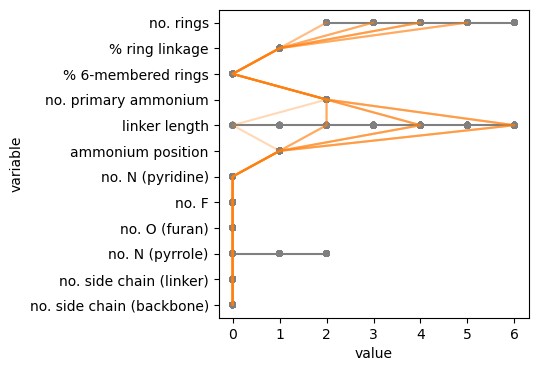

In [67]:
dataframe_melt = pd.melt(type_IIa_candidate_dataframe, id_vars=['smiles_canonical','pubchem_existence'], value_vars=COLUMNS_DICT['machine_learning_features'])
fig, ax = plt.subplots(figsize=(4, 4))

(
    so.Plot(data=dataframe_melt, 
            x='value', y='variable')
    .add(so.Dots(color='grey'))
    .add(so.Range(color='grey'))
    .add(so.Line(color='tab:orange',alpha=0.3), data=dataframe_melt.query('pubchem_existence == True'), group = 'smiles_canonical')
    .theme(axes_style('ticks'))
    .on(ax)

    .plot()
    
)
ax.set_yticklabels(['no. rings', '% ring linkage', '% 6-membered rings','no. primary ammonium', 'linker length', 'ammonium position', 'no. N (pyridine)', 'no. F', 'no. O (furan)', 'no. N (pyrrole)', 'no. side chain (linker)', 'no. side chain (backbone)'])
fig.savefig('../rawfigures/type_IIa_1_candidate_features.svg')

/var/folders/tn/23sfm0zs5f725m1tjsjgv1tc0000gn/T/ipykernel_13577/3142955093.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['no. rings', '% ring linkage', '% 6-membered rings','no. primary ammonium', 'linker length', 'ammonium position', 'no. N (pyridine)', 'no. F', 'no. O (furan)', 'no. N (pyrrole)', 'no. side chain (linker)', 'no. side chain (backbone)'])


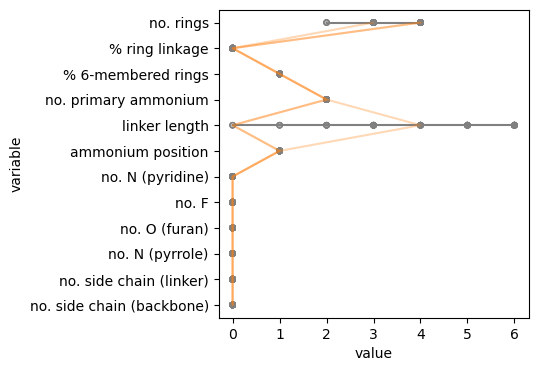

In [66]:
dataframe_melt = pd.melt(type_IIa_candidate_2_dataframe, id_vars=['smiles_canonical','pubchem_existence'], value_vars=COLUMNS_DICT['machine_learning_features'])
fig, ax = plt.subplots(figsize=(4, 4))

(
    so.Plot(data=dataframe_melt, 
            x='value', y='variable')
    .add(so.Dots(color='grey'))
    .add(so.Range(color='grey'))
    .add(so.Line(color='tab:orange',alpha=0.3), data=dataframe_melt.query('pubchem_existence == True'), group = 'smiles_canonical')
    .theme(axes_style('ticks'))
    .on(ax)

    .plot()
    
)
ax.set_yticklabels(['no. rings', '% ring linkage', '% 6-membered rings','no. primary ammonium', 'linker length', 'ammonium position', 'no. N (pyridine)', 'no. F', 'no. O (furan)', 'no. N (pyrrole)', 'no. side chain (linker)', 'no. side chain (backbone)'])
fig.savefig('../rawfigures/type_IIa_2_candidate_features.svg')

/var/folders/tn/23sfm0zs5f725m1tjsjgv1tc0000gn/T/ipykernel_13577/3271905874.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['no. rings', '% ring linkage', '% 6-membered rings','no. primary ammonium', 'linker length', 'ammonium position', 'no. N (pyridine)', 'no. F', 'no. O (furan)', 'no. N (pyrrole)', 'no. side chain (linker)', 'no. side chain (backbone)'])


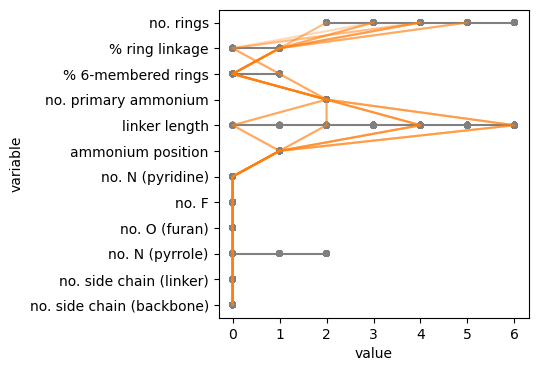

In [69]:
dataframe_melt = pd.melt(pd.concat([type_IIa_candidate_dataframe, type_IIa_candidate_2_dataframe], axis=0), id_vars=['smiles_canonical','pubchem_existence'], value_vars=COLUMNS_DICT['machine_learning_features'])
fig, ax = plt.subplots(figsize=(4, 4))

(
    so.Plot(data=dataframe_melt, 
            x='value', y='variable')
    .add(so.Dots(color='grey'))
    .add(so.Range(color='grey'))
    .add(so.Line(color='tab:orange',alpha=0.3), data=dataframe_melt.query('pubchem_existence == True'), group = 'smiles_canonical')
    .theme(axes_style('ticks'))
    .on(ax)

    .plot()
    
)
ax.set_yticklabels(['no. rings', '% ring linkage', '% 6-membered rings','no. primary ammonium', 'linker length', 'ammonium position', 'no. N (pyridine)', 'no. F', 'no. O (furan)', 'no. N (pyrrole)', 'no. side chain (linker)', 'no. side chain (backbone)'])
fig.savefig('../rawfigures/type_IIa_candidate_features.svg')

/var/folders/tn/23sfm0zs5f725m1tjsjgv1tc0000gn/T/ipykernel_13577/3530735012.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['no. rings', '% ring linkage', '% 6-membered rings','no. primary ammonium', 'linker length', 'ammonium position', 'no. N (pyridine)', 'no. F', 'no. O (furan)', 'no. N (pyrrole)', 'no. side chain (linker)', 'no. side chain (backbone)'])


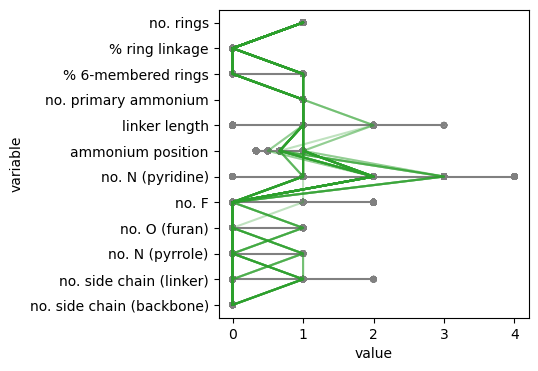

In [63]:
dataframe_melt = pd.melt(type_IIb_candidate_dataframe, id_vars=['smiles_canonical','pubchem_existence'], value_vars=COLUMNS_DICT['machine_learning_features'])
fig, ax = plt.subplots(figsize=(4, 4))

(
    so.Plot(data=dataframe_melt, 
            x='value', y='variable')
    .add(so.Dots(color='grey'))
    .add(so.Range(color='grey'))
    .add(so.Line(color='tab:green',alpha=0.3), data=dataframe_melt.query('pubchem_existence == True'), group = 'smiles_canonical')
    .theme(axes_style('ticks'))
    .on(ax)

    .plot()
    
)
ax.set_yticklabels(['no. rings', '% ring linkage', '% 6-membered rings','no. primary ammonium', 'linker length', 'ammonium position', 'no. N (pyridine)', 'no. F', 'no. O (furan)', 'no. N (pyrrole)', 'no. side chain (linker)', 'no. side chain (backbone)'])
fig.savefig('../rawfigures/type_IIb_candidate_features.svg')